<a href="https://colab.research.google.com/github/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/blob/master/VN_Capacity_WiP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Shelter Capacity Data Preparation
- Vernon Naidoo
- 2020-07-17

# Setup (Libraries, Functions, Data)

- DataFrame: daily_shelter_occupancy
- Import Libraries
- Build Custom Functions
- Load and Concatenate Data Files

## Import Libraries

In [188]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

!pip install squarify
import squarify

#np.random(42)

%config InlineBackend.figure_format = 'retina'

## Build Custom Functions

In [189]:
def get_tree_colors(value_series):
  # Get colours
  cmap = matplotlib.cm.prism # coolwarm
  # Min and Max Values
  mini = min(value_series); maxi = max(value_series)
  # Finding Colors for each tile
  norm = matplotlib.colors.Normalize(vmin=mini, vmax=maxi)
  colors = [cmap(norm(value)) for value in value_series]
  return colors

In [190]:
# Take a random sample of x records from DataFrame y:
def sample(df,number_of_records):
  display(df.loc[np.random.choice(len(df),number_of_records),:])
  #print('DataFrame has length',len(df), 'and shape',df.shape,'.')
  print(f'Random sample of {number_of_records} rows from DataFrame with {df.shape[0]} records and {df.shape[1]} columns.')

## Load and Concatenate Data Files

In [191]:
# Load files from GitHub; add year labels
path = 'https://raw.githubusercontent.com/VernonNaidoo-Toronto/Understanding-Toronto-Shelters/master/Shelter%20Data/'
dso2017 = pd.read_csv(path + 'daily-shelter-occupancy-2017-csv.csv', 
                    parse_dates=['OCCUPANCY_DATE']); dso2017['source_file']=2017
dso2018 = pd.read_csv(path + 'daily-shelter-occupancy-2018-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2018['source_file']=2018
dso2019 = pd.read_csv(path + 'daily-shelter-occupancy-2019-csv.csv',
                    parse_dates=['OCCUPANCY_DATE']); dso2019['source_file']=2019

# Get summary of records loaded
for year, df in [[2017,dso2017], [2018,dso2018], [2019,dso2019]]:
  print(f'Loaded {df.shape[0]} records and {df.shape[1]} columns from the {year} file.')

Loaded 38700 records and 14 columns from the 2017 file.
Loaded 37770 records and 14 columns from the 2018 file.
Loaded 39446 records and 14 columns from the 2019 file.


In [192]:
# Concatenate DataFrames
daily_shelter_occupancy = pd.concat([dso2017, dso2018, dso2019], ignore_index=True) 

# Get list of column names; change to Python standard lowercase:
cols = [column_name.lower() for column_name in daily_shelter_occupancy.columns] 
daily_shelter_occupancy.columns = cols

# Move source_file column to front of DataFrame
cols = cols[-1:] + cols[0:-1]
daily_shelter_occupancy = daily_shelter_occupancy[cols]

# Show sample records
sample(daily_shelter_occupancy,5)

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
83433,2019,6964,2019-03-07,Society of St.Vincent De Paul,SVDP - Mary's Home,70 Gerrard St. E.,Toronto,ON,M5B 1G6,SVDP - Mary's Home,SVDP - Mary's Home Extreme Weather Program,Women,6,6.0
91844,2019,15375,2019-05-24,Eva's Initiatives,Eva's Satellite,25 Canterbury Place,North York,ON,M2N OE3,Eva's Satellite,Eva's Satellite Extreme Weather Program,Youth,1,1.0
79519,2019,3050,2019-01-30,City of Toronto,Birkdale Residence,1229 Ellesmere Road,Toronto,ON,M1P 4V8,Birkdale Residence,Birkdale Residence - Bedded Program,Families,172,160.0
108202,2019,31733,2019-10-23,Homes First Society,HFS - Scarborough Shelter,3576 St. Clair Avenue East,Scarborough,ON,M1K 1M2,HFS-545 Lakeshore Blvd W.Couple,545 Lakeshore Blvd. W.Couple,Co-ed,99,106.0
92574,2019,16105,2019-05-31,City of Toronto,Downsview Dells,1651 Sheppard Ave West,Toronto,ON,M3M 2X4,Downsview Dells 1651 Sheppard W,Downsview Dells Bedded Program,Men,25,28.0


Random sample of 5 rows from DataFrame with 115916 records and 14 columns.


# Analyze Imported Data

## Data Types

In [193]:
daily_shelter_occupancy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115916 entries, 0 to 115915
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   source_file          115916 non-null  int64         
 1   _id                  115916 non-null  int64         
 2   occupancy_date       115916 non-null  datetime64[ns]
 3   organization_name    115916 non-null  object        
 4   shelter_name         115916 non-null  object        
 5   shelter_address      115916 non-null  object        
 6   shelter_city         115916 non-null  object        
 7   shelter_province     115916 non-null  object        
 8   shelter_postal_code  110422 non-null  object        
 9   facility_name        115916 non-null  object        
 10  program_name         115916 non-null  object        
 11  sector               115916 non-null  object        
 12  occupancy            115916 non-null  int64         
 13  capacity      

## Drop Nulls; Fix Data Types


- The shelter_postal_code column has 5494 missing values.
- The capacity column has 343 missing values.
  - 11 of those (null capacity) rows have occupancy values, which total 43 - all in 2017
  - All 343 rows were dropped.

In [194]:
# Identify columns with missing values:
for col in daily_shelter_occupancy.columns:
  null_count = daily_shelter_occupancy[col].isna().sum()
  if null_count >0:
    print(f'The {col} column has {null_count} rows without values.')

The shelter_postal_code column has 5494 rows without values.
The capacity column has 343 rows without values.


In [195]:
# Drop 343 rows with null capacity
original_row_count=daily_shelter_occupancy.shape[0]
daily_shelter_occupancy.dropna(subset=['capacity'], inplace=True)
dropped_row_count=original_row_count-daily_shelter_occupancy.shape[0]
print(f'Dropped {dropped_row_count} of {original_row_count} rows, due to nulls in capacity column.')

Dropped 343 of 115916 rows, due to nulls in capacity column.


In [196]:
# After removing nulls, change capacity column to integer
daily_shelter_occupancy.capacity = daily_shelter_occupancy.capacity.astype(int)

## Unique Value Analysis


- Logical hierarchies:
  1. shelter_province (1)
    - shelter_city (4)
      - shelter_address (65)
  2. organization_name (33)
    - facility_name (144)
      - program_name (155)

In [197]:
# Count unique values in each column:
for col in daily_shelter_occupancy.columns:
  value_count = len(daily_shelter_occupancy[col].unique())
  print(col,value_count)

source_file 3
_id 39446
occupancy_date 1095
organization_name 32
shelter_name 63
shelter_address 64
shelter_city 4
shelter_province 1
shelter_postal_code 62
facility_name 109
program_name 143
sector 5
occupancy 673
capacity 266


# Create daily downsample with new vacancy and occupancy_rate columns

In [198]:
daily = daily_shelter_occupancy.set_index('occupancy_date')\
  .resample('D')[['occupancy','capacity']].sum()
daily['vacancy']=daily.capacity - daily.occupancy
daily['occupancy_rate']=daily.occupancy/daily.capacity*100
display(daily.head())

,occupancy,capacity,vacancy,occupancy_rate
occupancy_date,,,,
2017-01-01,4295,4653,358,92.306039
2017-01-02,4299,4704,405,91.390306
2017-01-03,4386,4733,347,92.668498
2017-01-04,4600,4938,338,93.155124
2017-01-05,4729,5011,282,94.372381


# Plot Occupancy, Capacity Trends

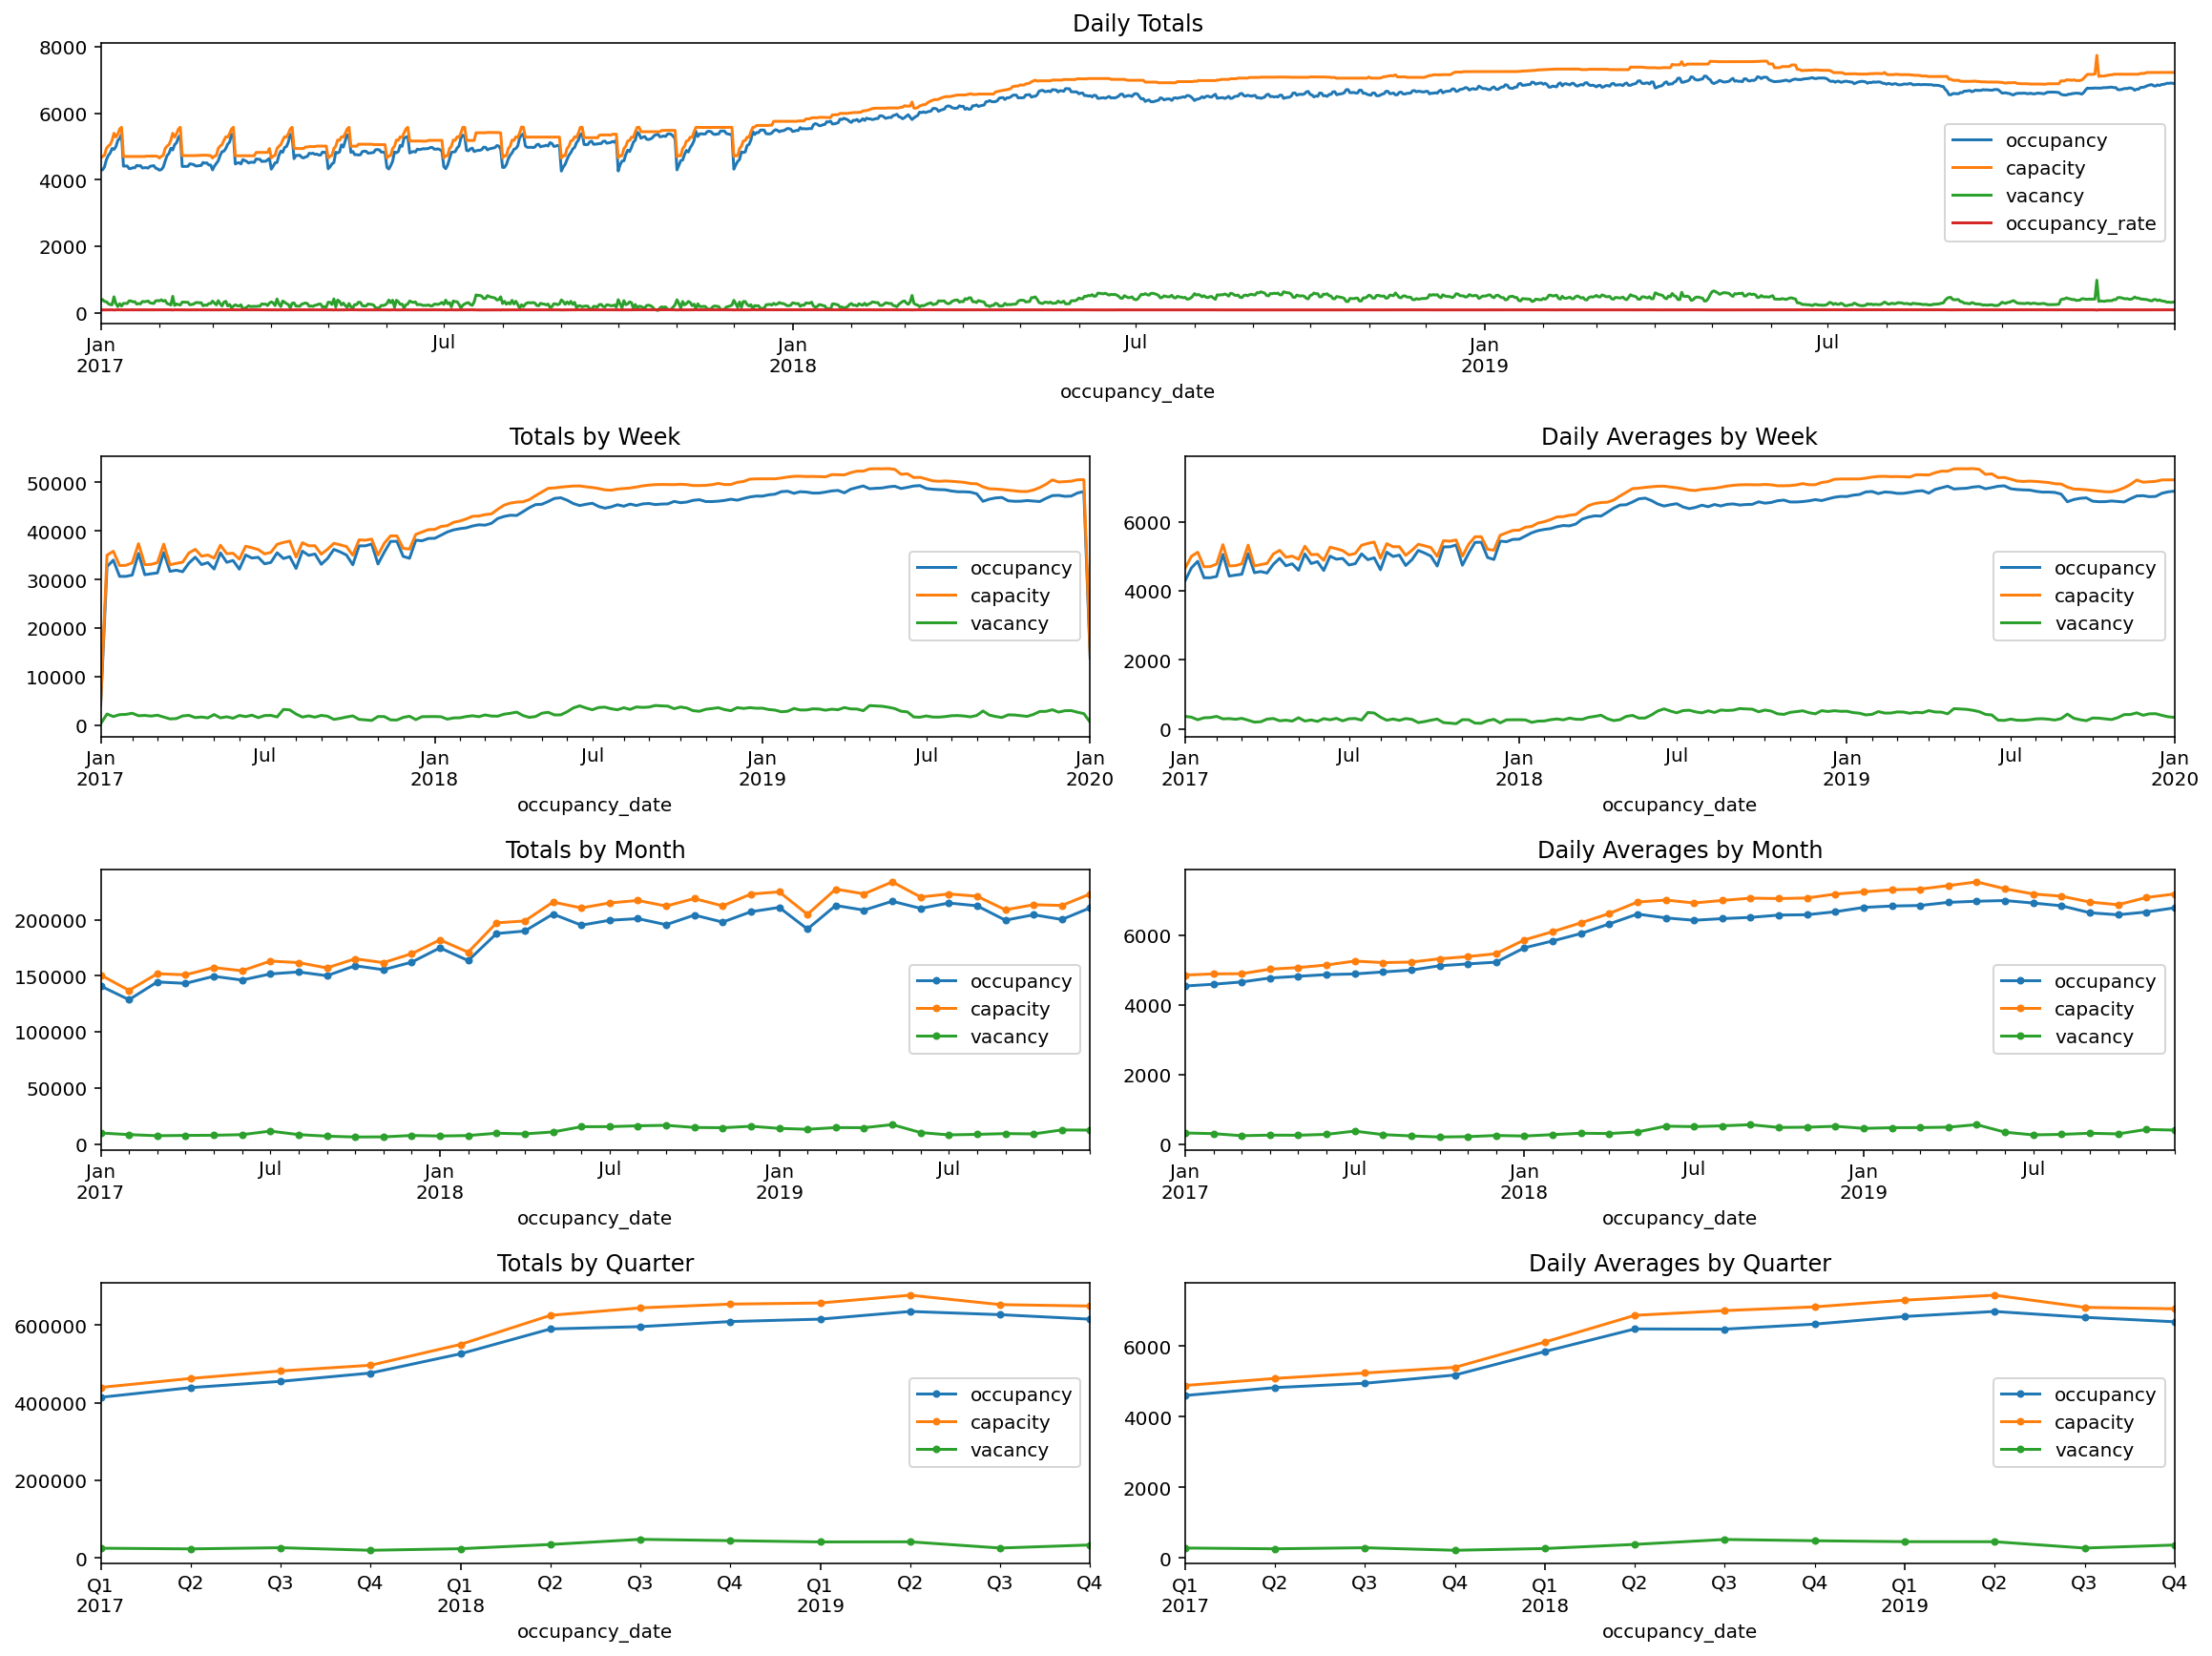

In [199]:
# Trends:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (1, 1))
ax5 = plt.subplot2grid((4, 2), (2, 0))
ax6 = plt.subplot2grid((4, 2), (2, 1))
ax7 = plt.subplot2grid((4, 2), (3, 0))
ax8 = plt.subplot2grid((4, 2), (3, 1))

# Plot day, week, month, quarter totals:
daily.plot(title='Daily Totals', ax=ax1)
daily.resample('W')[['occupancy','capacity','vacancy']].sum().plot(title='Totals by Week', ax=ax3)
daily.resample('M')[['occupancy','capacity','vacancy']].sum().plot(title='Totals by Month', ax=ax5, marker='.')
daily.resample('Q')[['occupancy','capacity','vacancy']].sum().plot(title='Totals by Quarter', ax=ax7, marker='.')

# Plot daily averages at week, month, quarter intervals
daily.resample('W')[['occupancy','capacity','vacancy']].mean().plot(title='Daily Averages by Week', ax=ax4)
daily.resample('M')[['occupancy','capacity','vacancy']].mean().plot(title='Daily Averages by Month', ax=ax6, marker='.')
daily.resample('Q')[['occupancy','capacity','vacancy']].mean().plot(title='Daily Averages by Quarter', ax=ax8, marker='.')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

# Plot Vacancy Trends

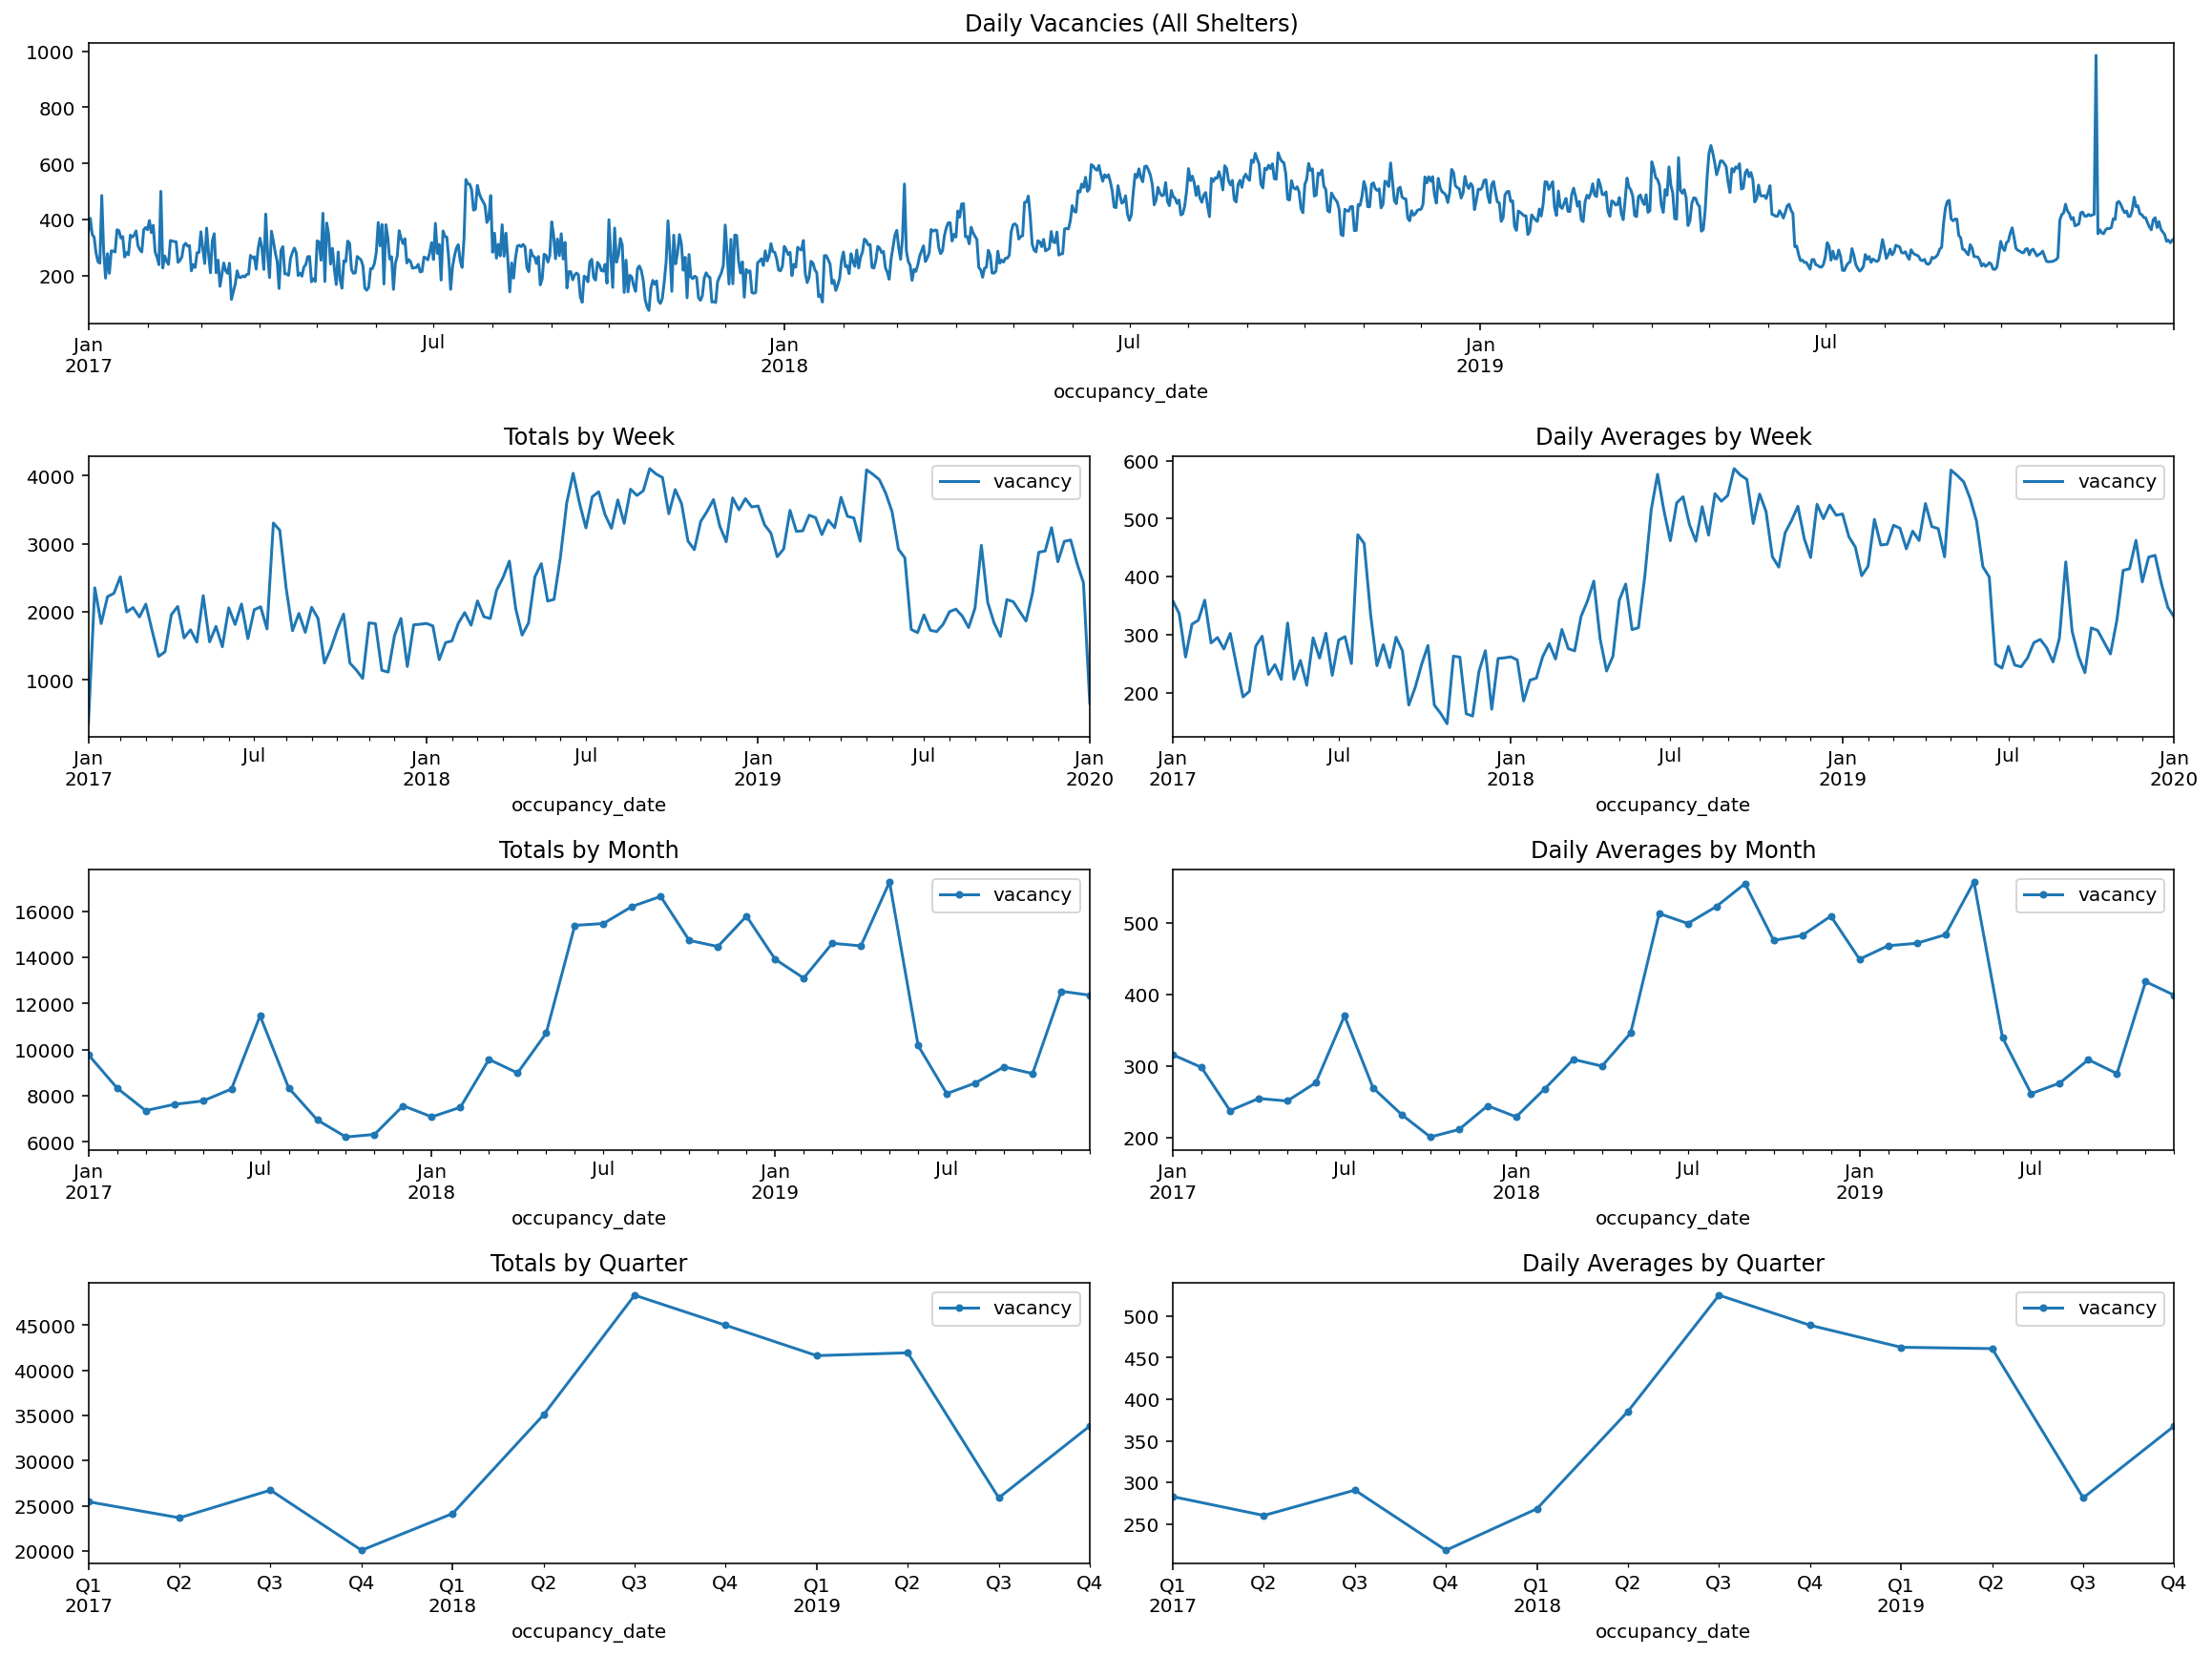

In [200]:
# Configure grid
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((4, 2), (0, 0), colspan=2)
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (1, 1))
ax5 = plt.subplot2grid((4, 2), (2, 0))
ax6 = plt.subplot2grid((4, 2), (2, 1))
ax7 = plt.subplot2grid((4, 2), (3, 0))
ax8 = plt.subplot2grid((4, 2), (3, 1))

# Plot totals by week, month, quarter
daily.vacancy.plot(title='Daily Vacancies (All Shelters)', ax=ax1)
daily.resample('W')[['vacancy']].sum().plot(title='Totals by Week', ax=ax3)
daily.resample('M')[['vacancy']].sum().plot(title='Totals by Month', ax=ax5, marker='.')
daily.resample('Q')[['vacancy']].sum().plot(title='Totals by Quarter', ax=ax7, marker='.')

# Plot daily averages at week, month, quarter intervals
daily.resample('W')[['vacancy']].mean().plot(title='Daily Averages by Week', ax=ax4)
daily.resample('M')[['vacancy']].mean().plot(title='Daily Averages by Month', ax=ax6, marker='.')
daily.resample('Q')[['vacancy']].mean().plot(title='Daily Averages by Quarter', ax=ax8, marker='.')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

# Plot Occupancy Rate Trends

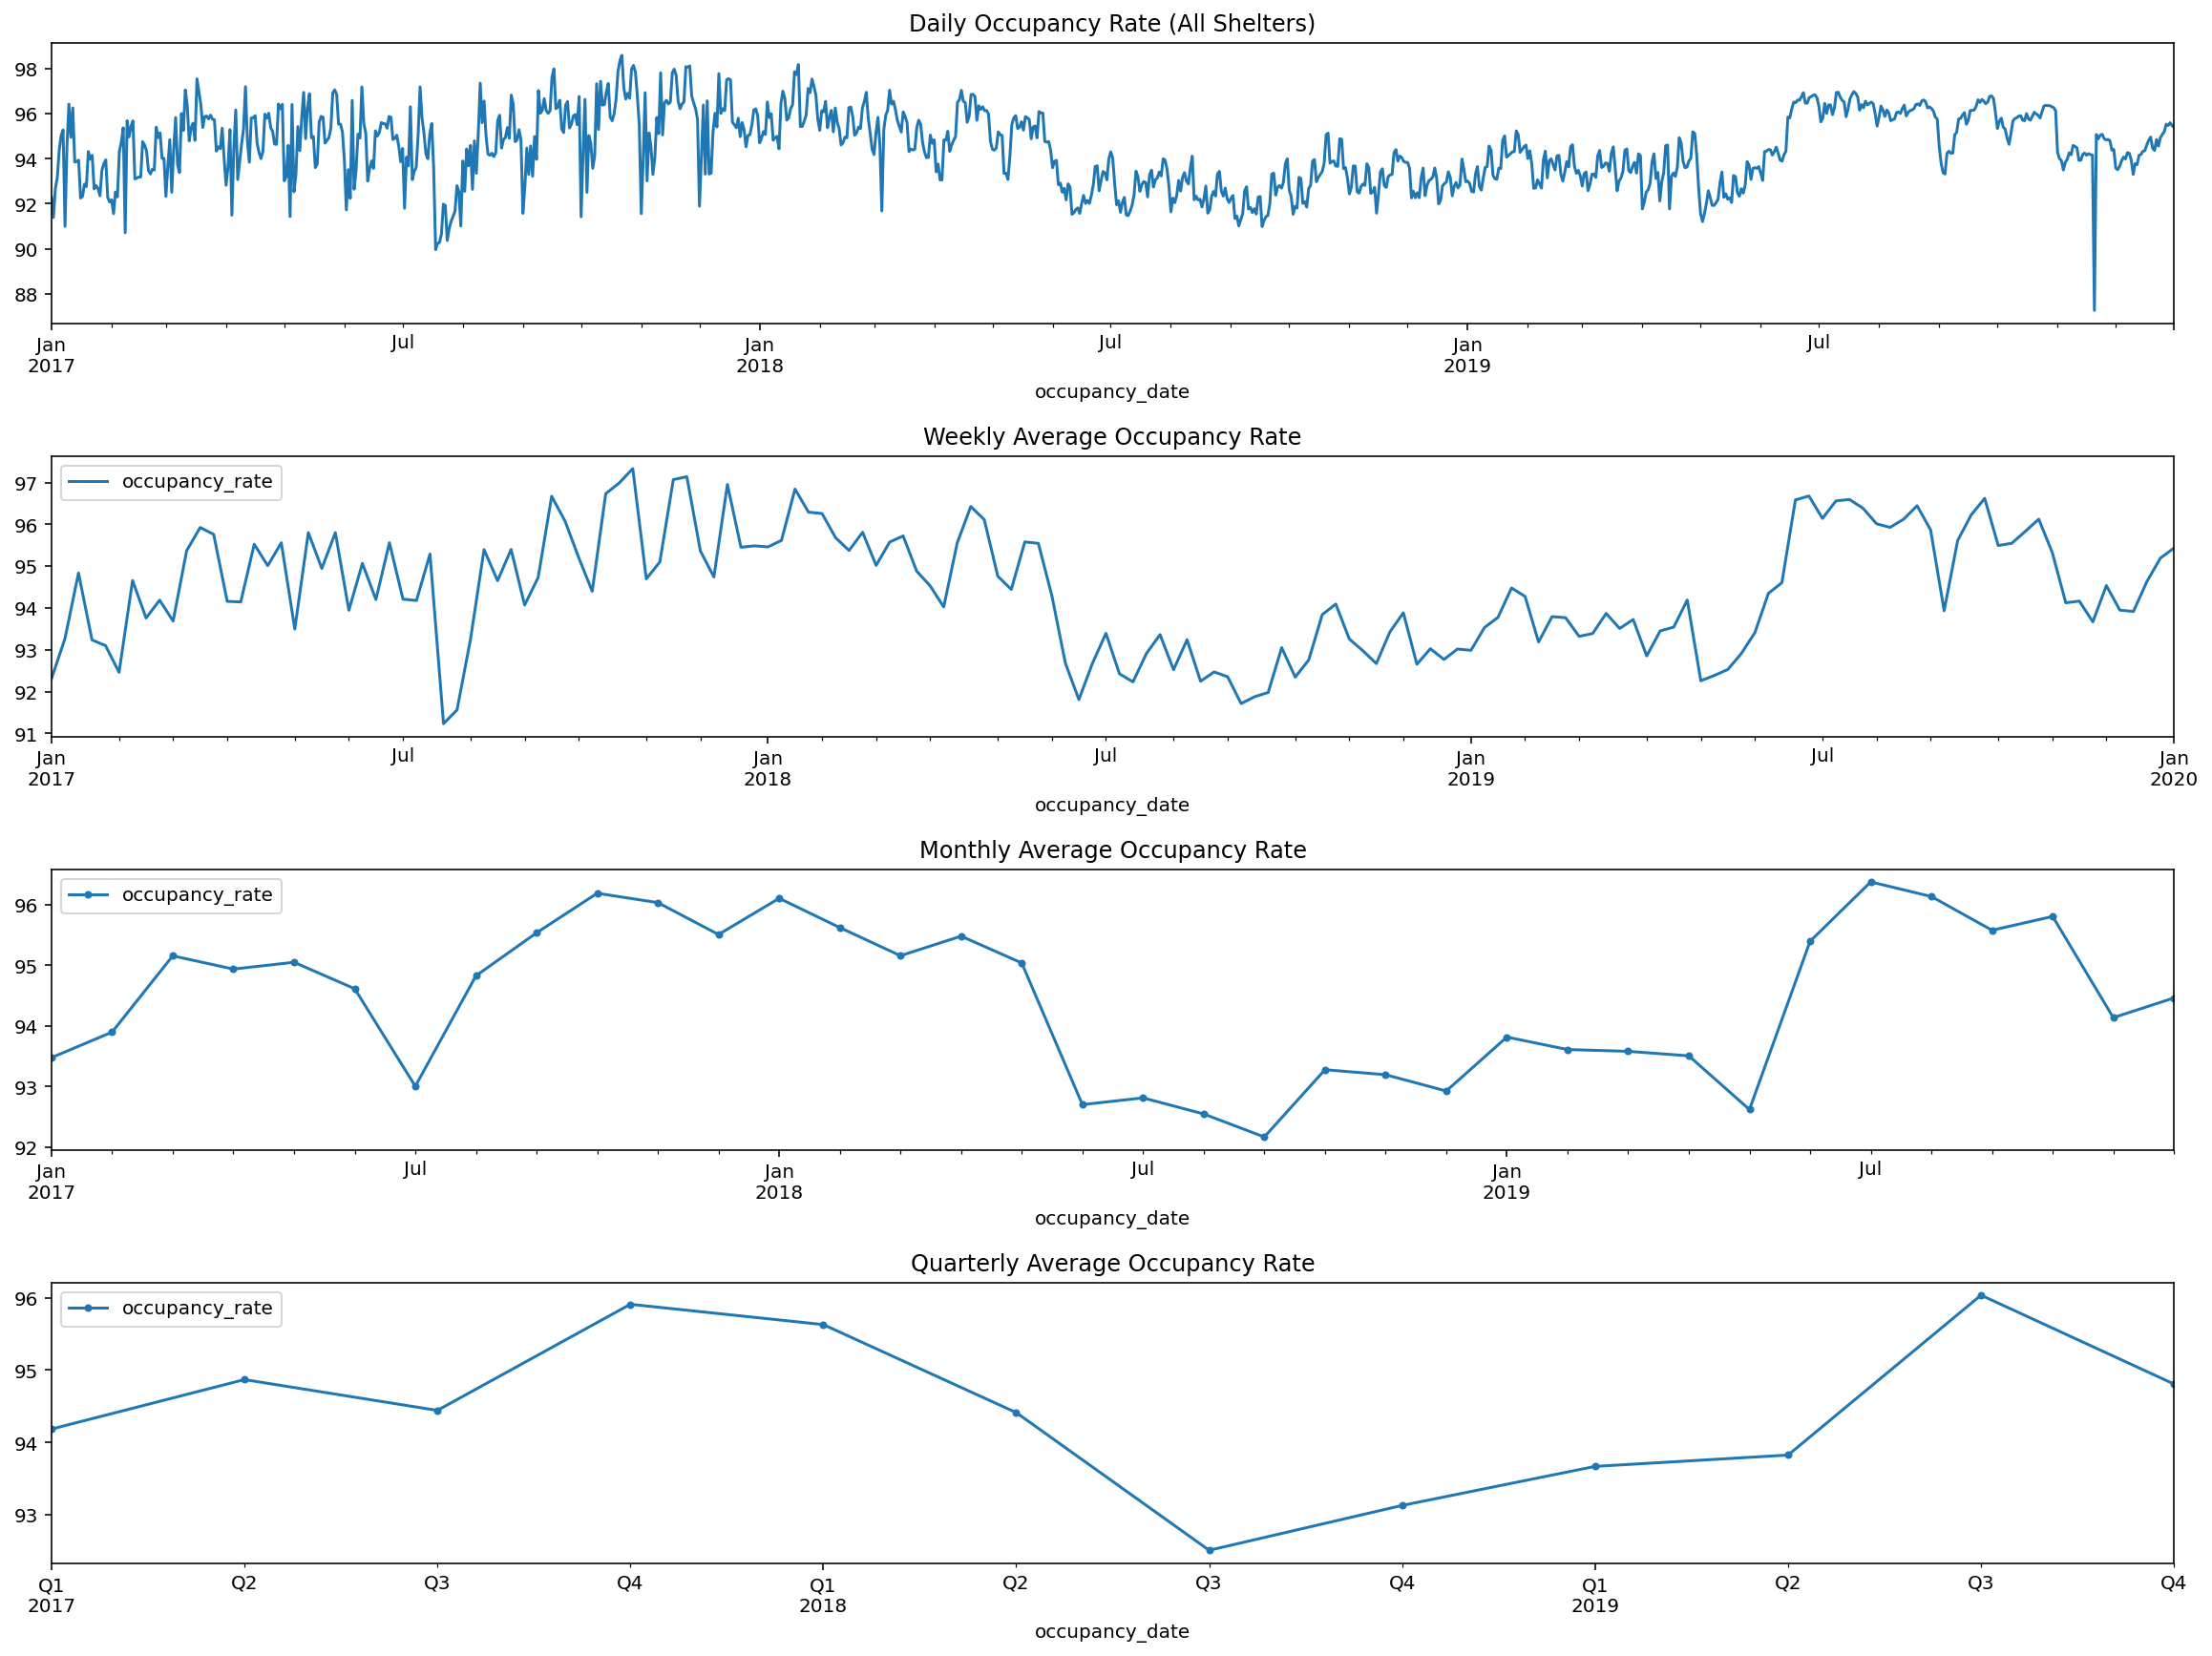

In [201]:
# Configure grid
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((4, 1), (0, 0))#, colspan=2)
ax2 = plt.subplot2grid((4, 1), (1, 0))
ax3 = plt.subplot2grid((4, 1), (2, 0))
ax4 = plt.subplot2grid((4, 1), (3, 0))

# Plot totals by week, month, quarter
daily.occupancy_rate.plot(title='Daily Occupancy Rate (All Shelters)', ax=ax1)
daily.resample('W')[['occupancy_rate']].mean().plot(title='Weekly Average Occupancy Rate', ax=ax2)
daily.resample('M')[['occupancy_rate']].mean().plot(title='Monthly Average Occupancy Rate', ax=ax3, marker='.')
daily.resample('Q')[['occupancy_rate']].mean().plot(title='Quarterly Average Occupancy Rate', ax=ax4, marker='.')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0);

#Distributions

## Capacity

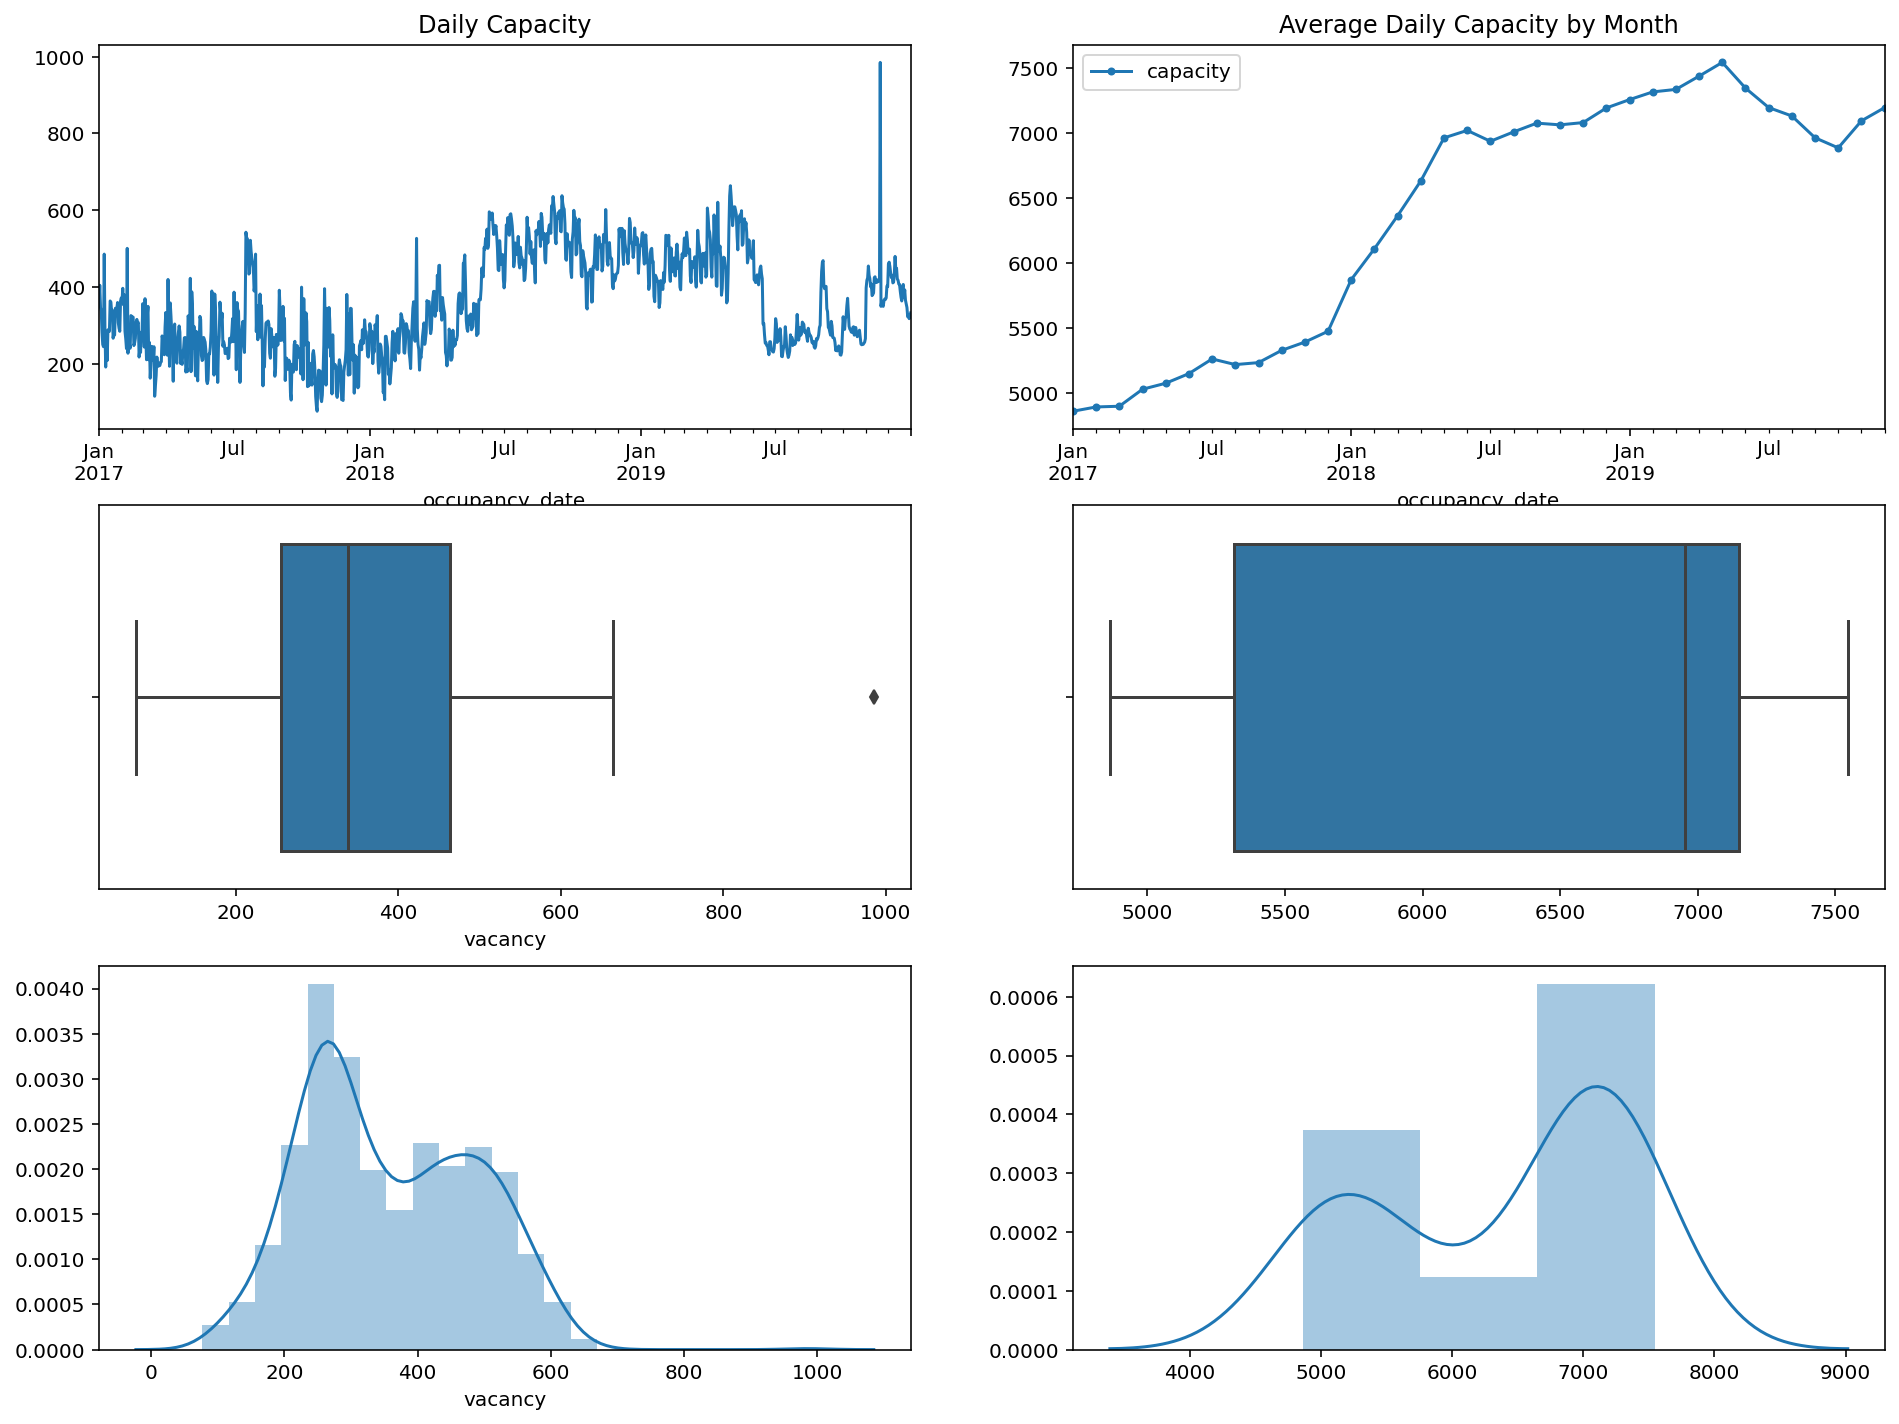

In [202]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0))#, colspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))#, colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0))
ax6 = plt.subplot2grid((3, 2), (2, 1))

daily.vacancy.plot(title='Daily Capacity', ax=ax1)
daily.resample('M')[['capacity']].mean().plot(title='Average Daily Capacity by Month', ax=ax2, marker='.')

sns.boxplot(daily.vacancy, ax=ax3);
sns.boxplot(daily.resample('M')[['capacity']].mean(), ax=ax4);

sns.distplot(daily.vacancy, ax=ax5);
sns.distplot(daily.loc[:,['capacity']].resample('M')[['capacity']].mean(), ax=ax6);

## Occupancy

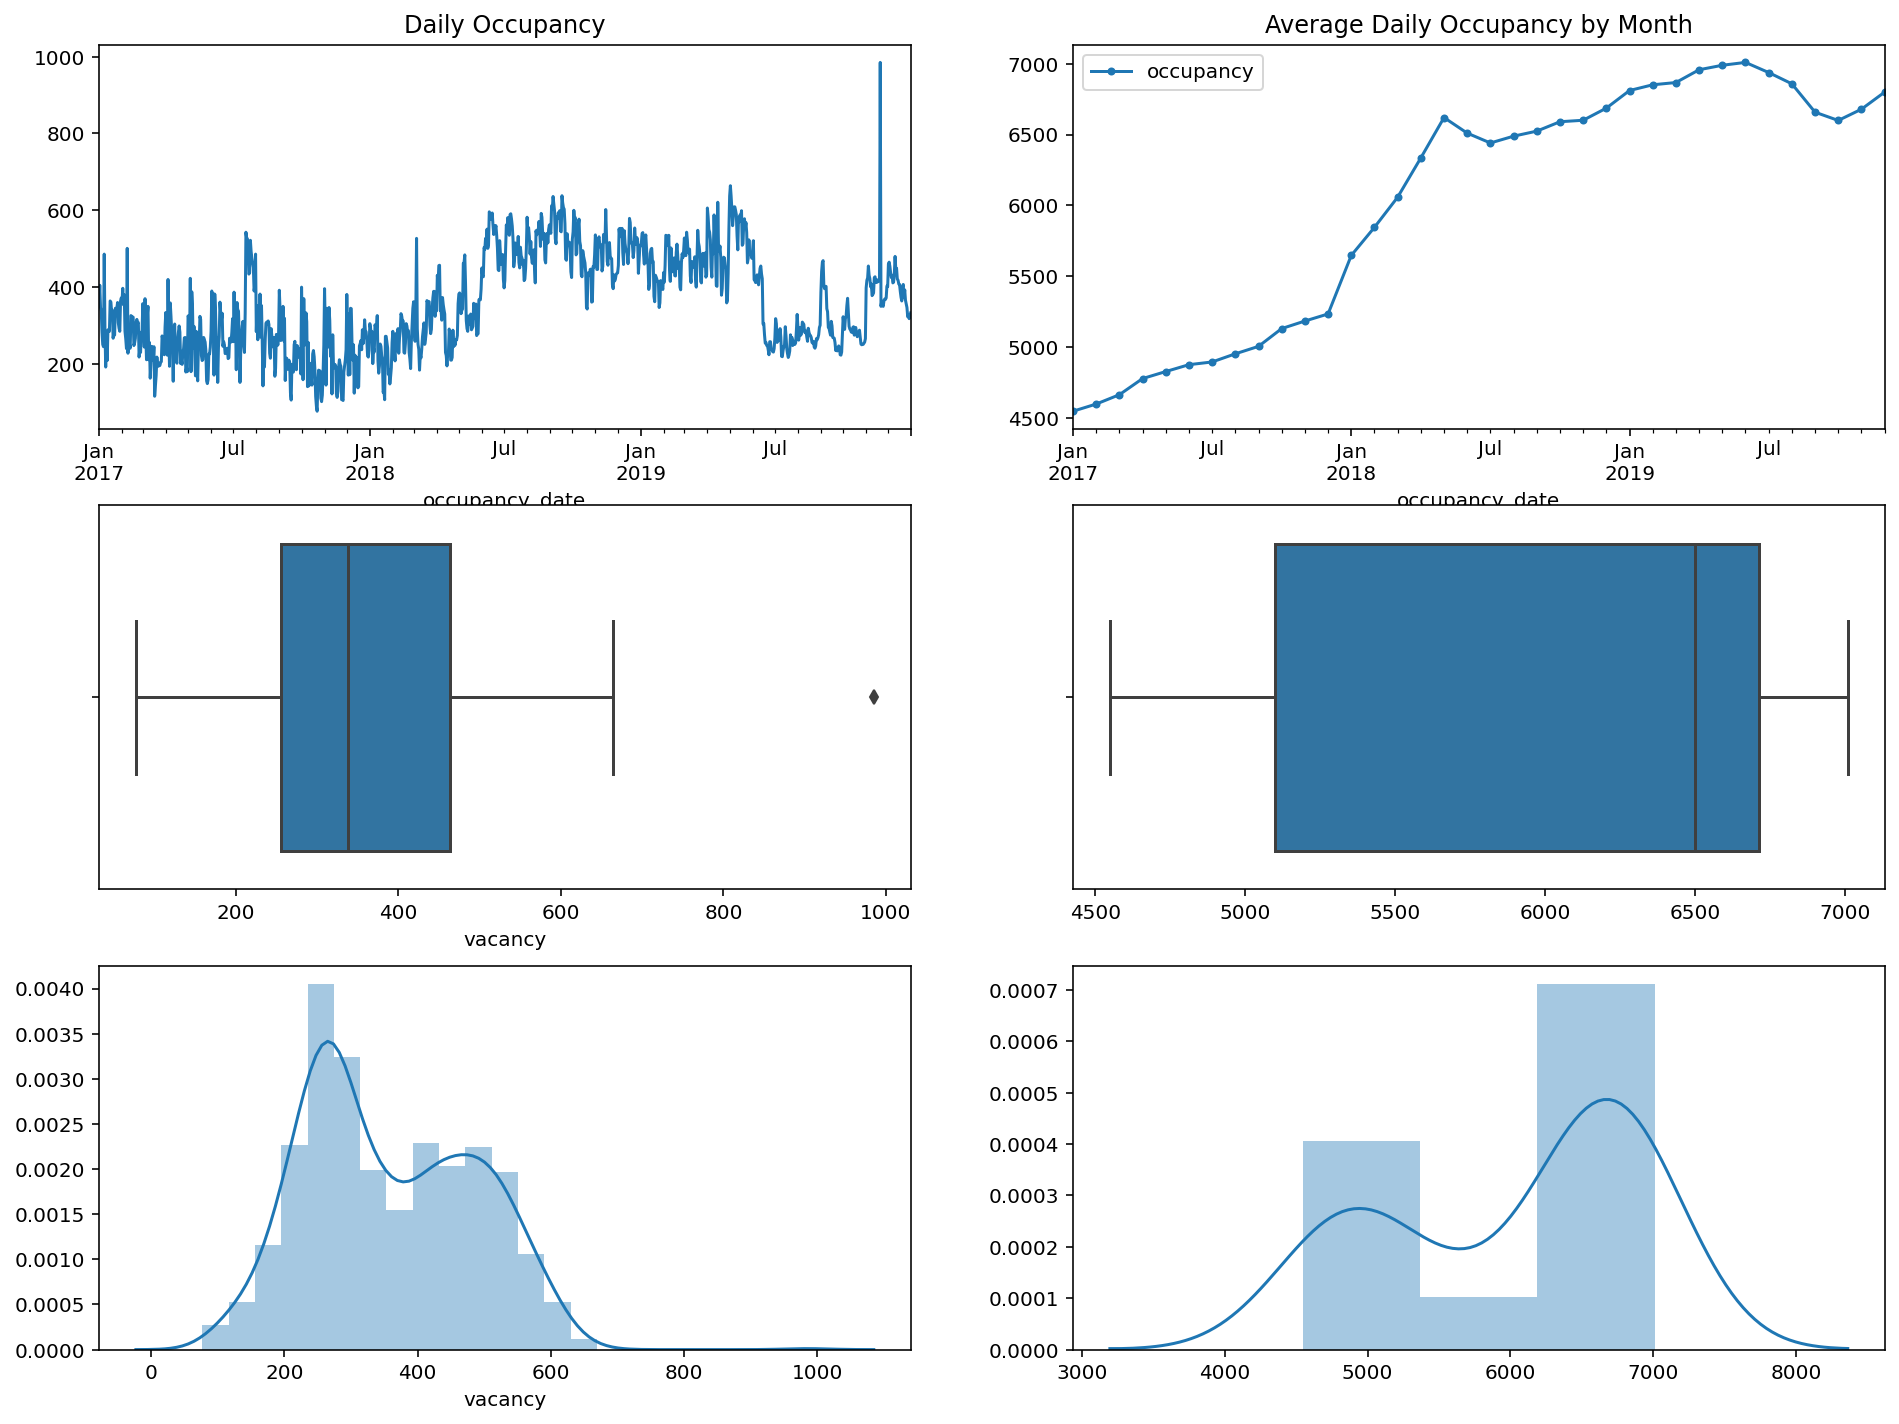

In [203]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0))#, colspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))#, colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0))
ax6 = plt.subplot2grid((3, 2), (2, 1))

daily.vacancy.plot(title='Daily Occupancy', ax=ax1)
daily.resample('M')[['occupancy']].mean().plot(title='Average Daily Occupancy by Month', ax=ax2, marker='.')

sns.boxplot(daily.vacancy, ax=ax3);
sns.boxplot(daily.resample('M')[['occupancy']].mean(), ax=ax4);

sns.distplot(daily.vacancy, ax=ax5);
sns.distplot(daily.loc[:,['occupancy']].resample('M')[['occupancy']].mean(), ax=ax6);

## Vacancy

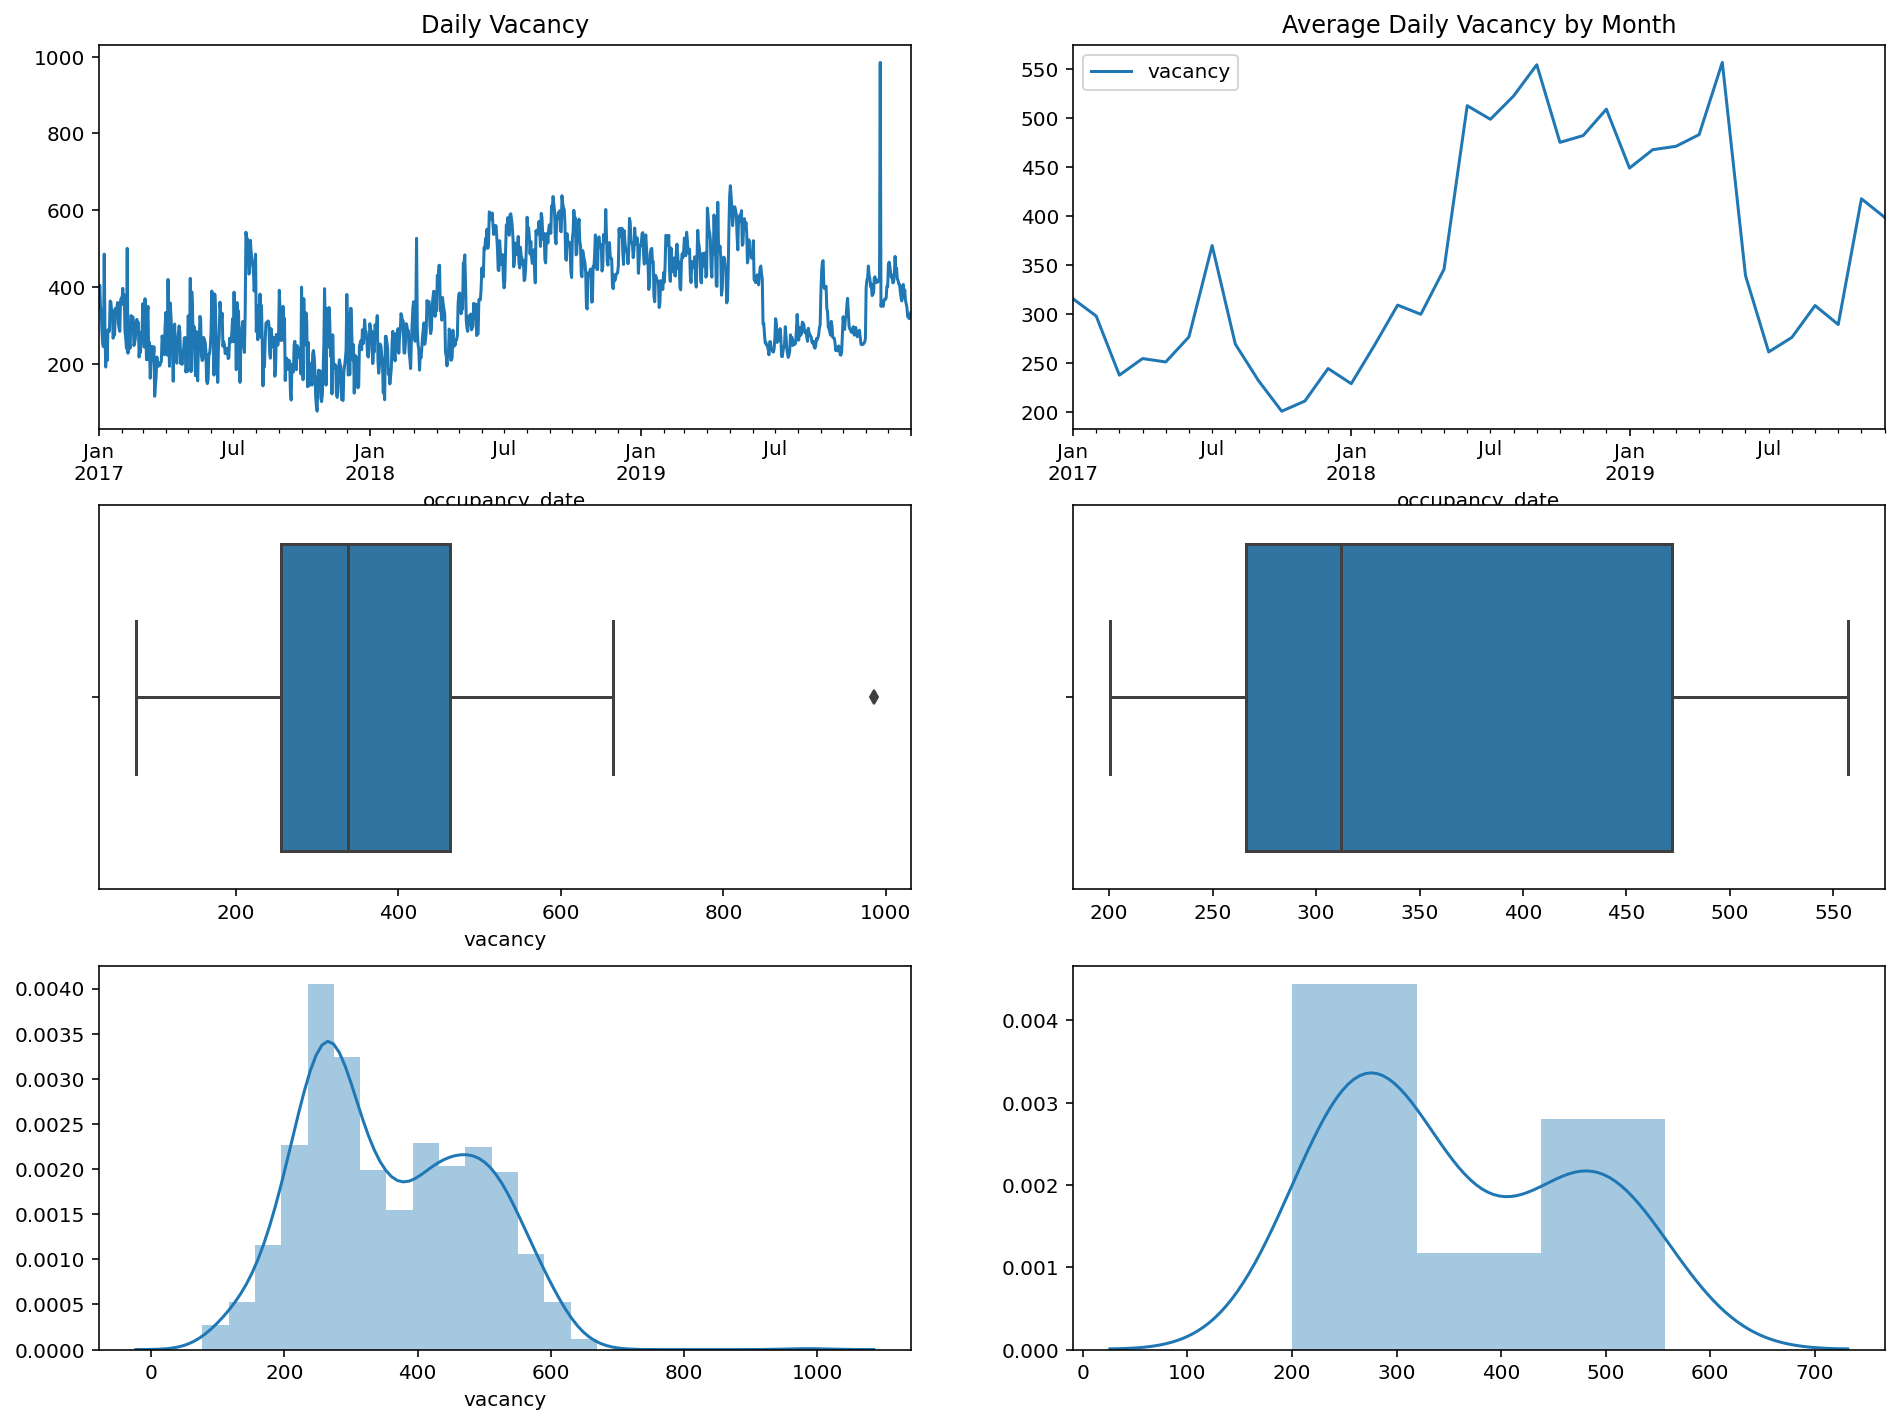

In [204]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0))#, colspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))#, colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0))
ax6 = plt.subplot2grid((3, 2), (2, 1))

daily.vacancy.plot(title='Daily Vacancy', ax=ax1)
daily.resample('M')[['vacancy']].mean().plot(title='Average Daily Vacancy by Month', ax=ax2)

sns.boxplot(daily.vacancy, ax=ax3);
sns.boxplot(daily.resample('M')[['vacancy']].mean(), ax=ax4);

sns.distplot(daily.vacancy, ax=ax5);
sns.distplot(daily.loc[:,['vacancy']].resample('M')[['vacancy']].mean(), ax=ax6);

## Occupancy Rate

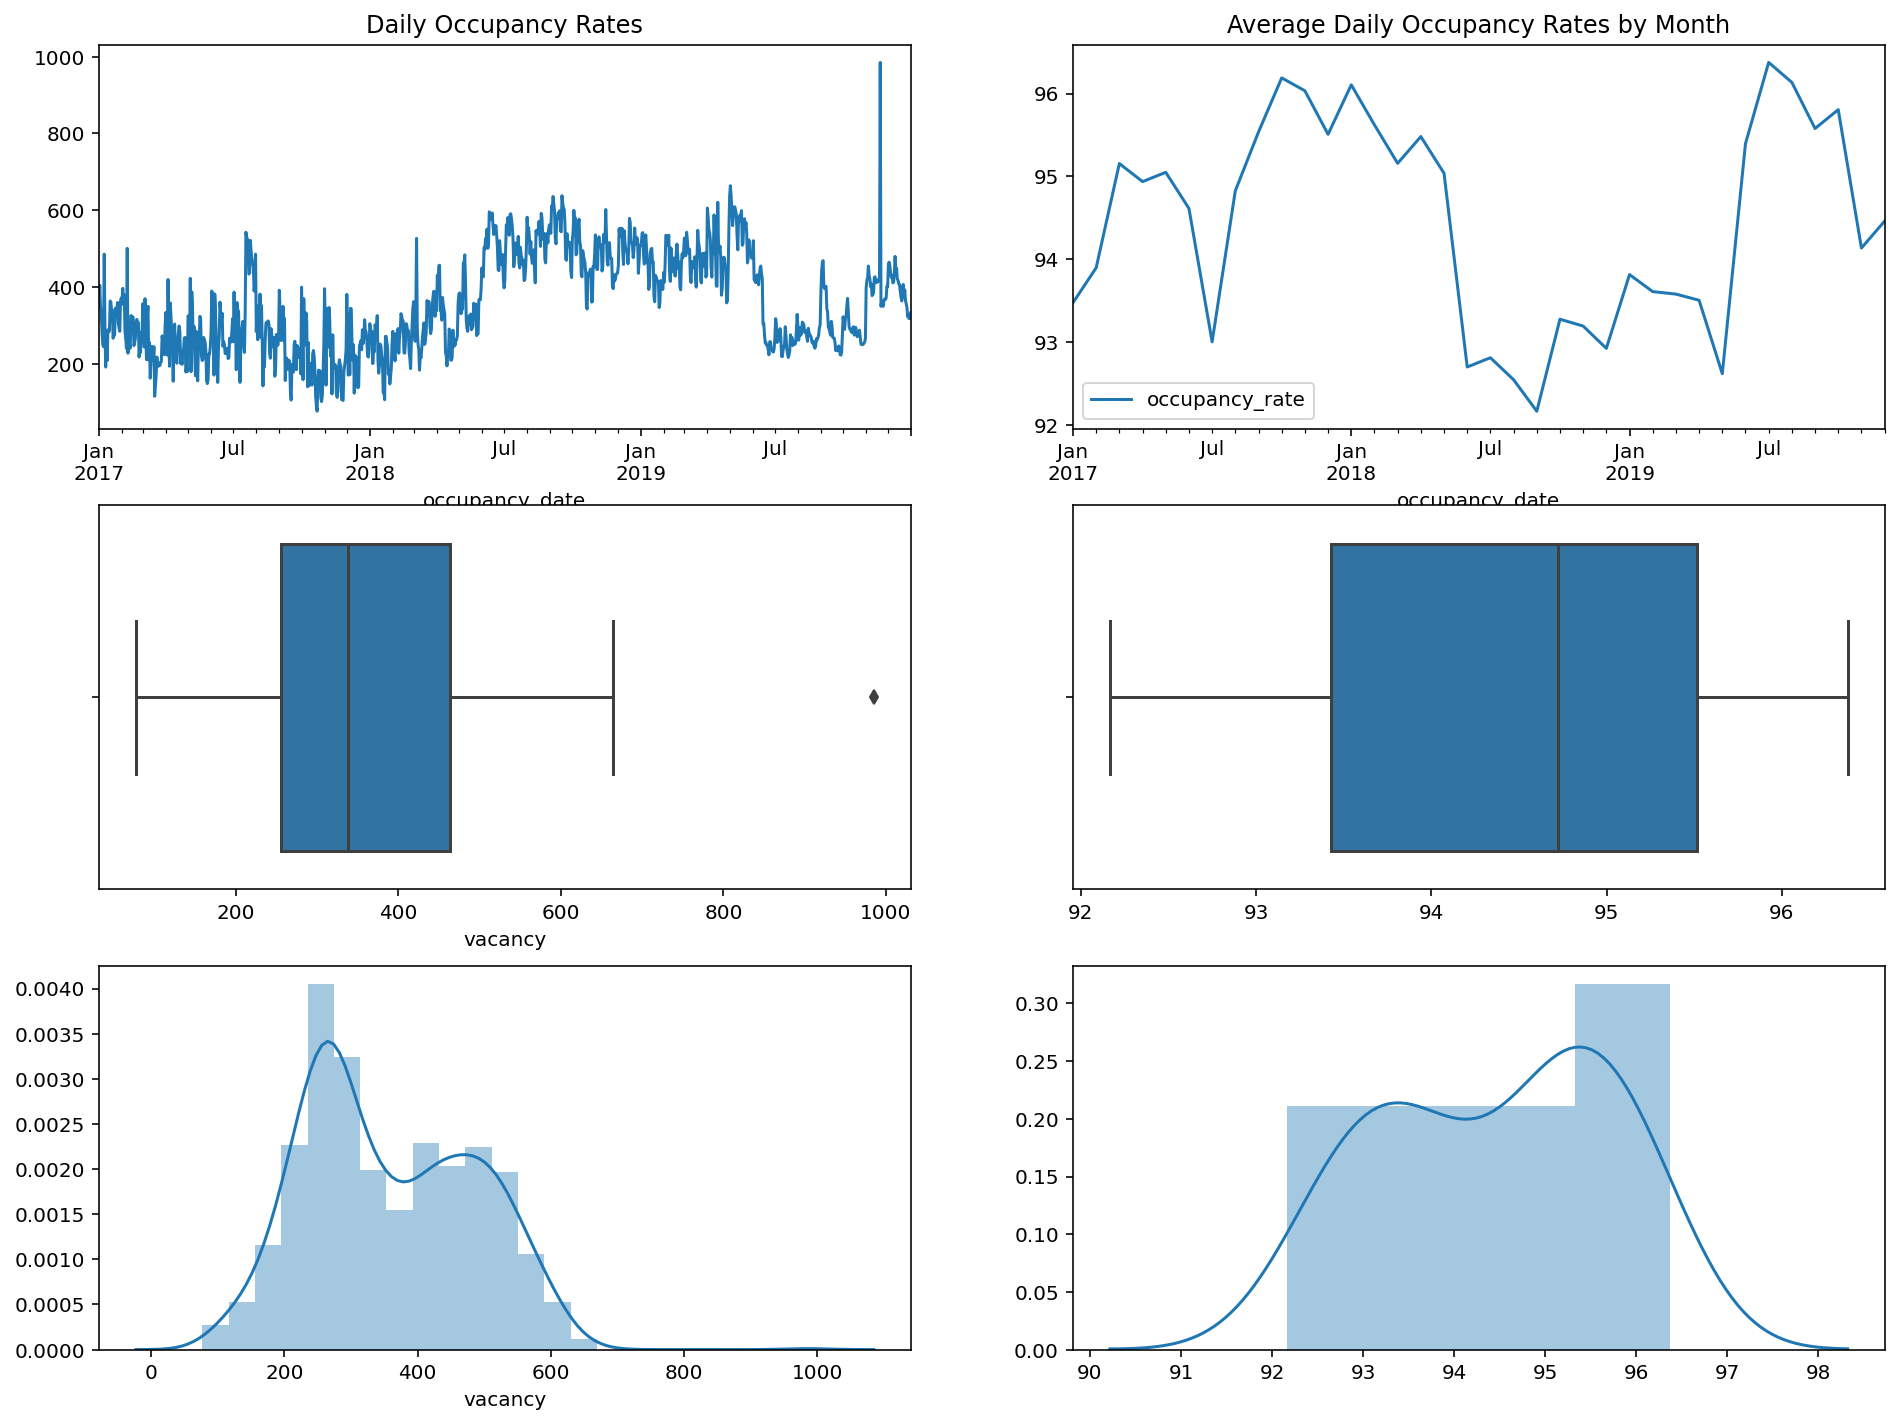

In [205]:
fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((3, 2), (0, 0))#, colspan=2)
ax2 = plt.subplot2grid((3, 2), (0, 1))
ax3 = plt.subplot2grid((3, 2), (1, 0))
ax4 = plt.subplot2grid((3, 2), (1, 1))#, colspan=2)
ax5 = plt.subplot2grid((3, 2), (2, 0))
ax6 = plt.subplot2grid((3, 2), (2, 1))

daily.vacancy.plot(title='Daily Occupancy Rates', ax=ax1)
daily.resample('M')[['occupancy_rate']].mean().plot(title='Average Daily Occupancy Rates by Month', ax=ax2)

sns.boxplot(daily.vacancy, ax=ax3);
sns.boxplot(daily.resample('M')[['occupancy_rate']].mean(), ax=ax4);

sns.distplot(daily.vacancy, ax=ax5);
sns.distplot(daily.loc[:,['occupancy_rate']].resample('M')[['occupancy_rate']].mean(), ax=ax6);

# FEATURE ANALYSIS

## Distribution of Data by City

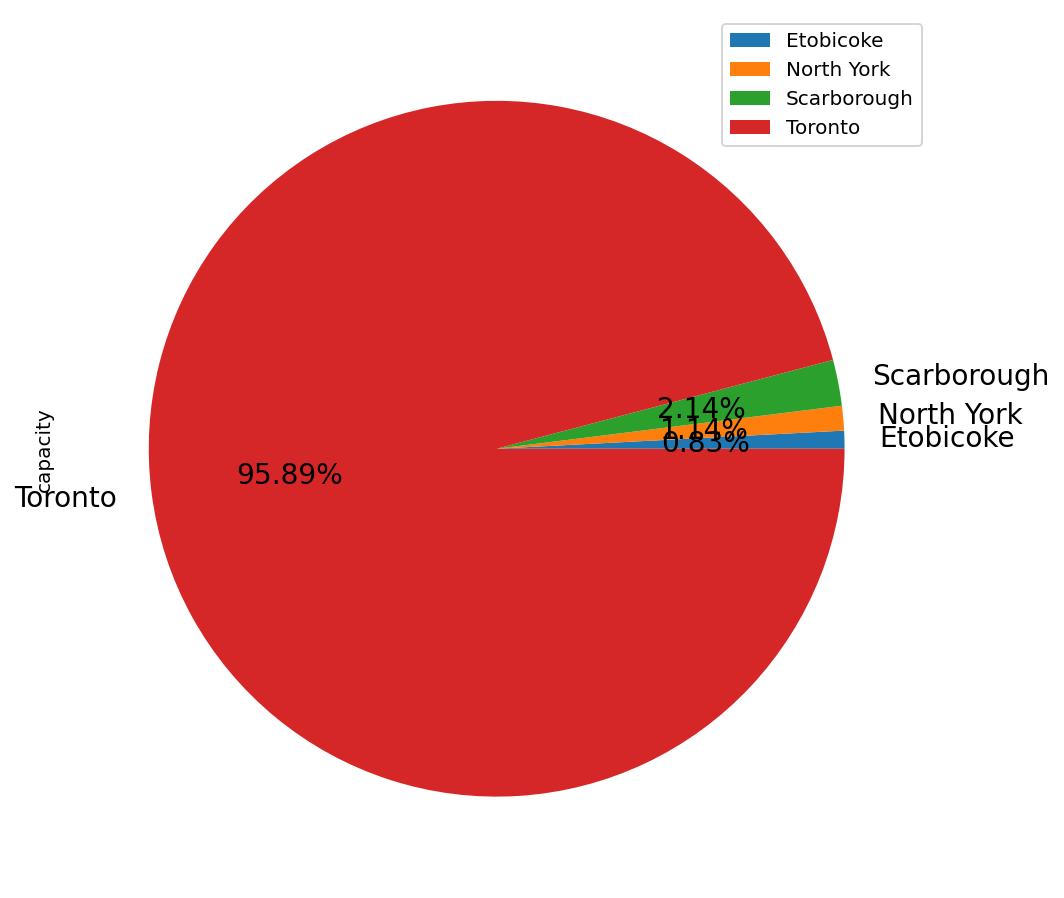

In [206]:
daily_shelter_occupancy.groupby(['shelter_city']).sum().plot.pie(y='capacity',figsize=(8,8),autopct='%1.2f%%', textprops={'fontsize': 14});

## Distribution of Data by Sector

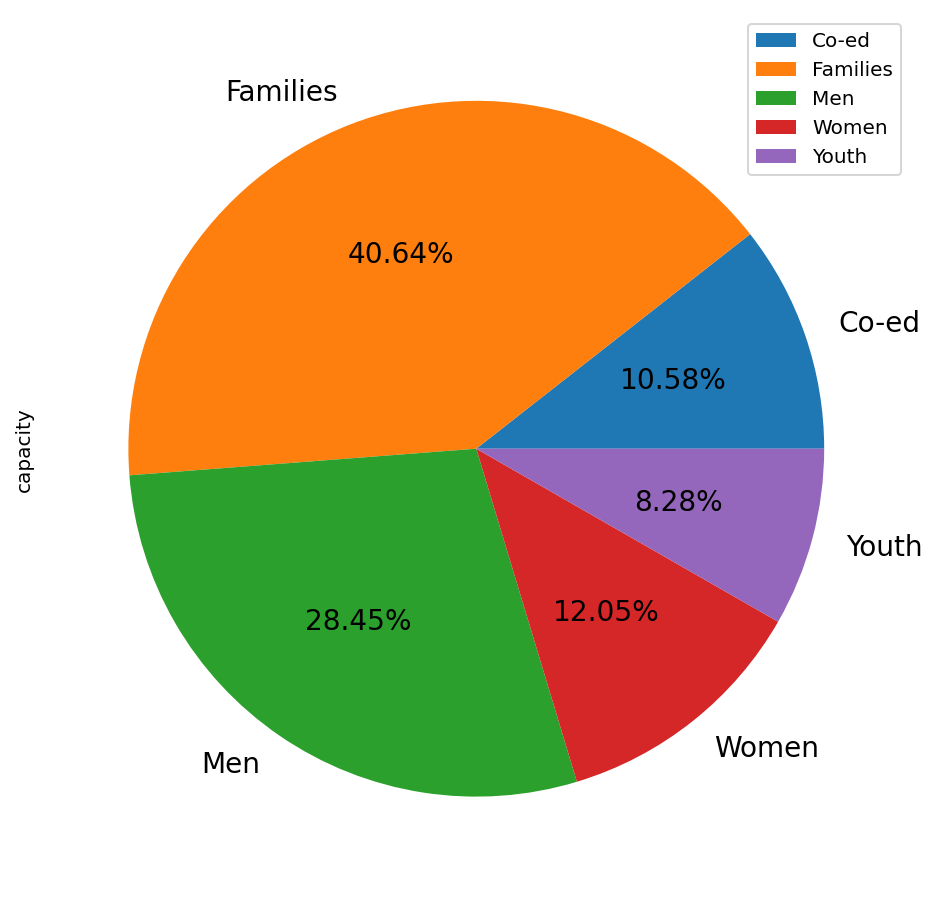

In [207]:
daily_shelter_occupancy.groupby(['sector']).sum().plot.pie(y='capacity',figsize=(8,8),autopct='%1.2f%%', textprops={'fontsize': 14});

## Top 5 Organizations

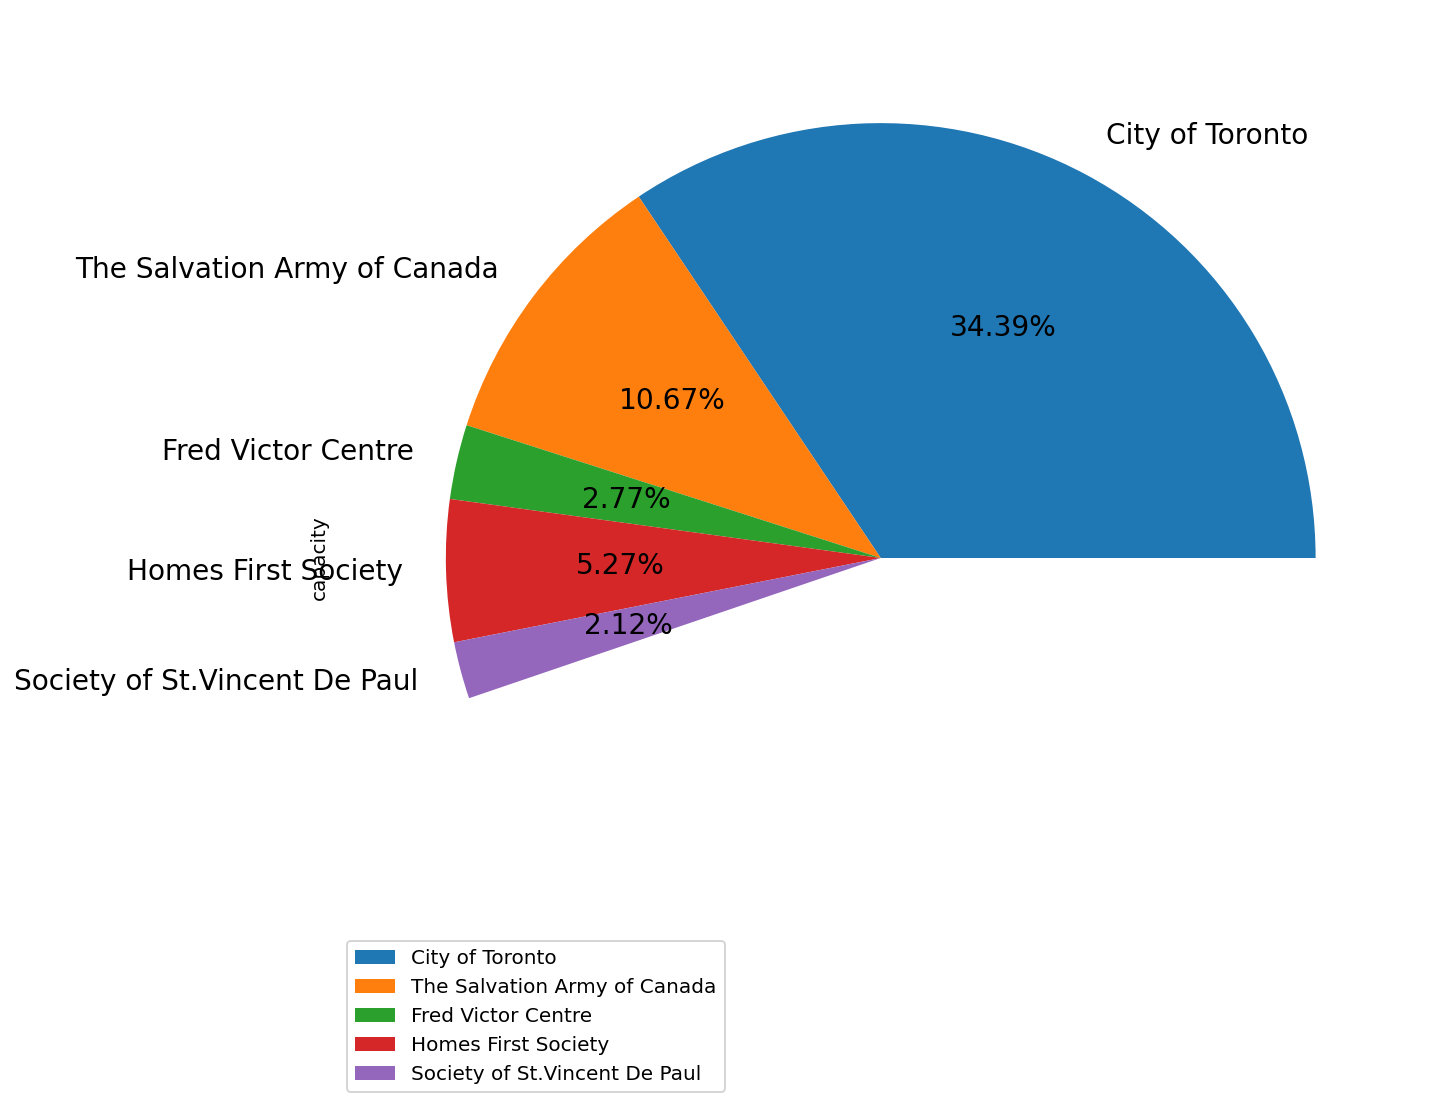

In [208]:
top_5 = daily_shelter_occupancy['organization_name'].value_counts()[:5].index.tolist()

df=daily_shelter_occupancy.groupby(['organization_name']).sum()
df=df.sort_values('capacity',ascending=False)#, inplace=True)
df.capacity=df.capacity/df.capacity.sum()
df.loc[top_5].plot.pie(y='capacity',figsize=(10,10),autopct='%1.2f%%', textprops={'fontsize': 14});

## Top 5 Facilities

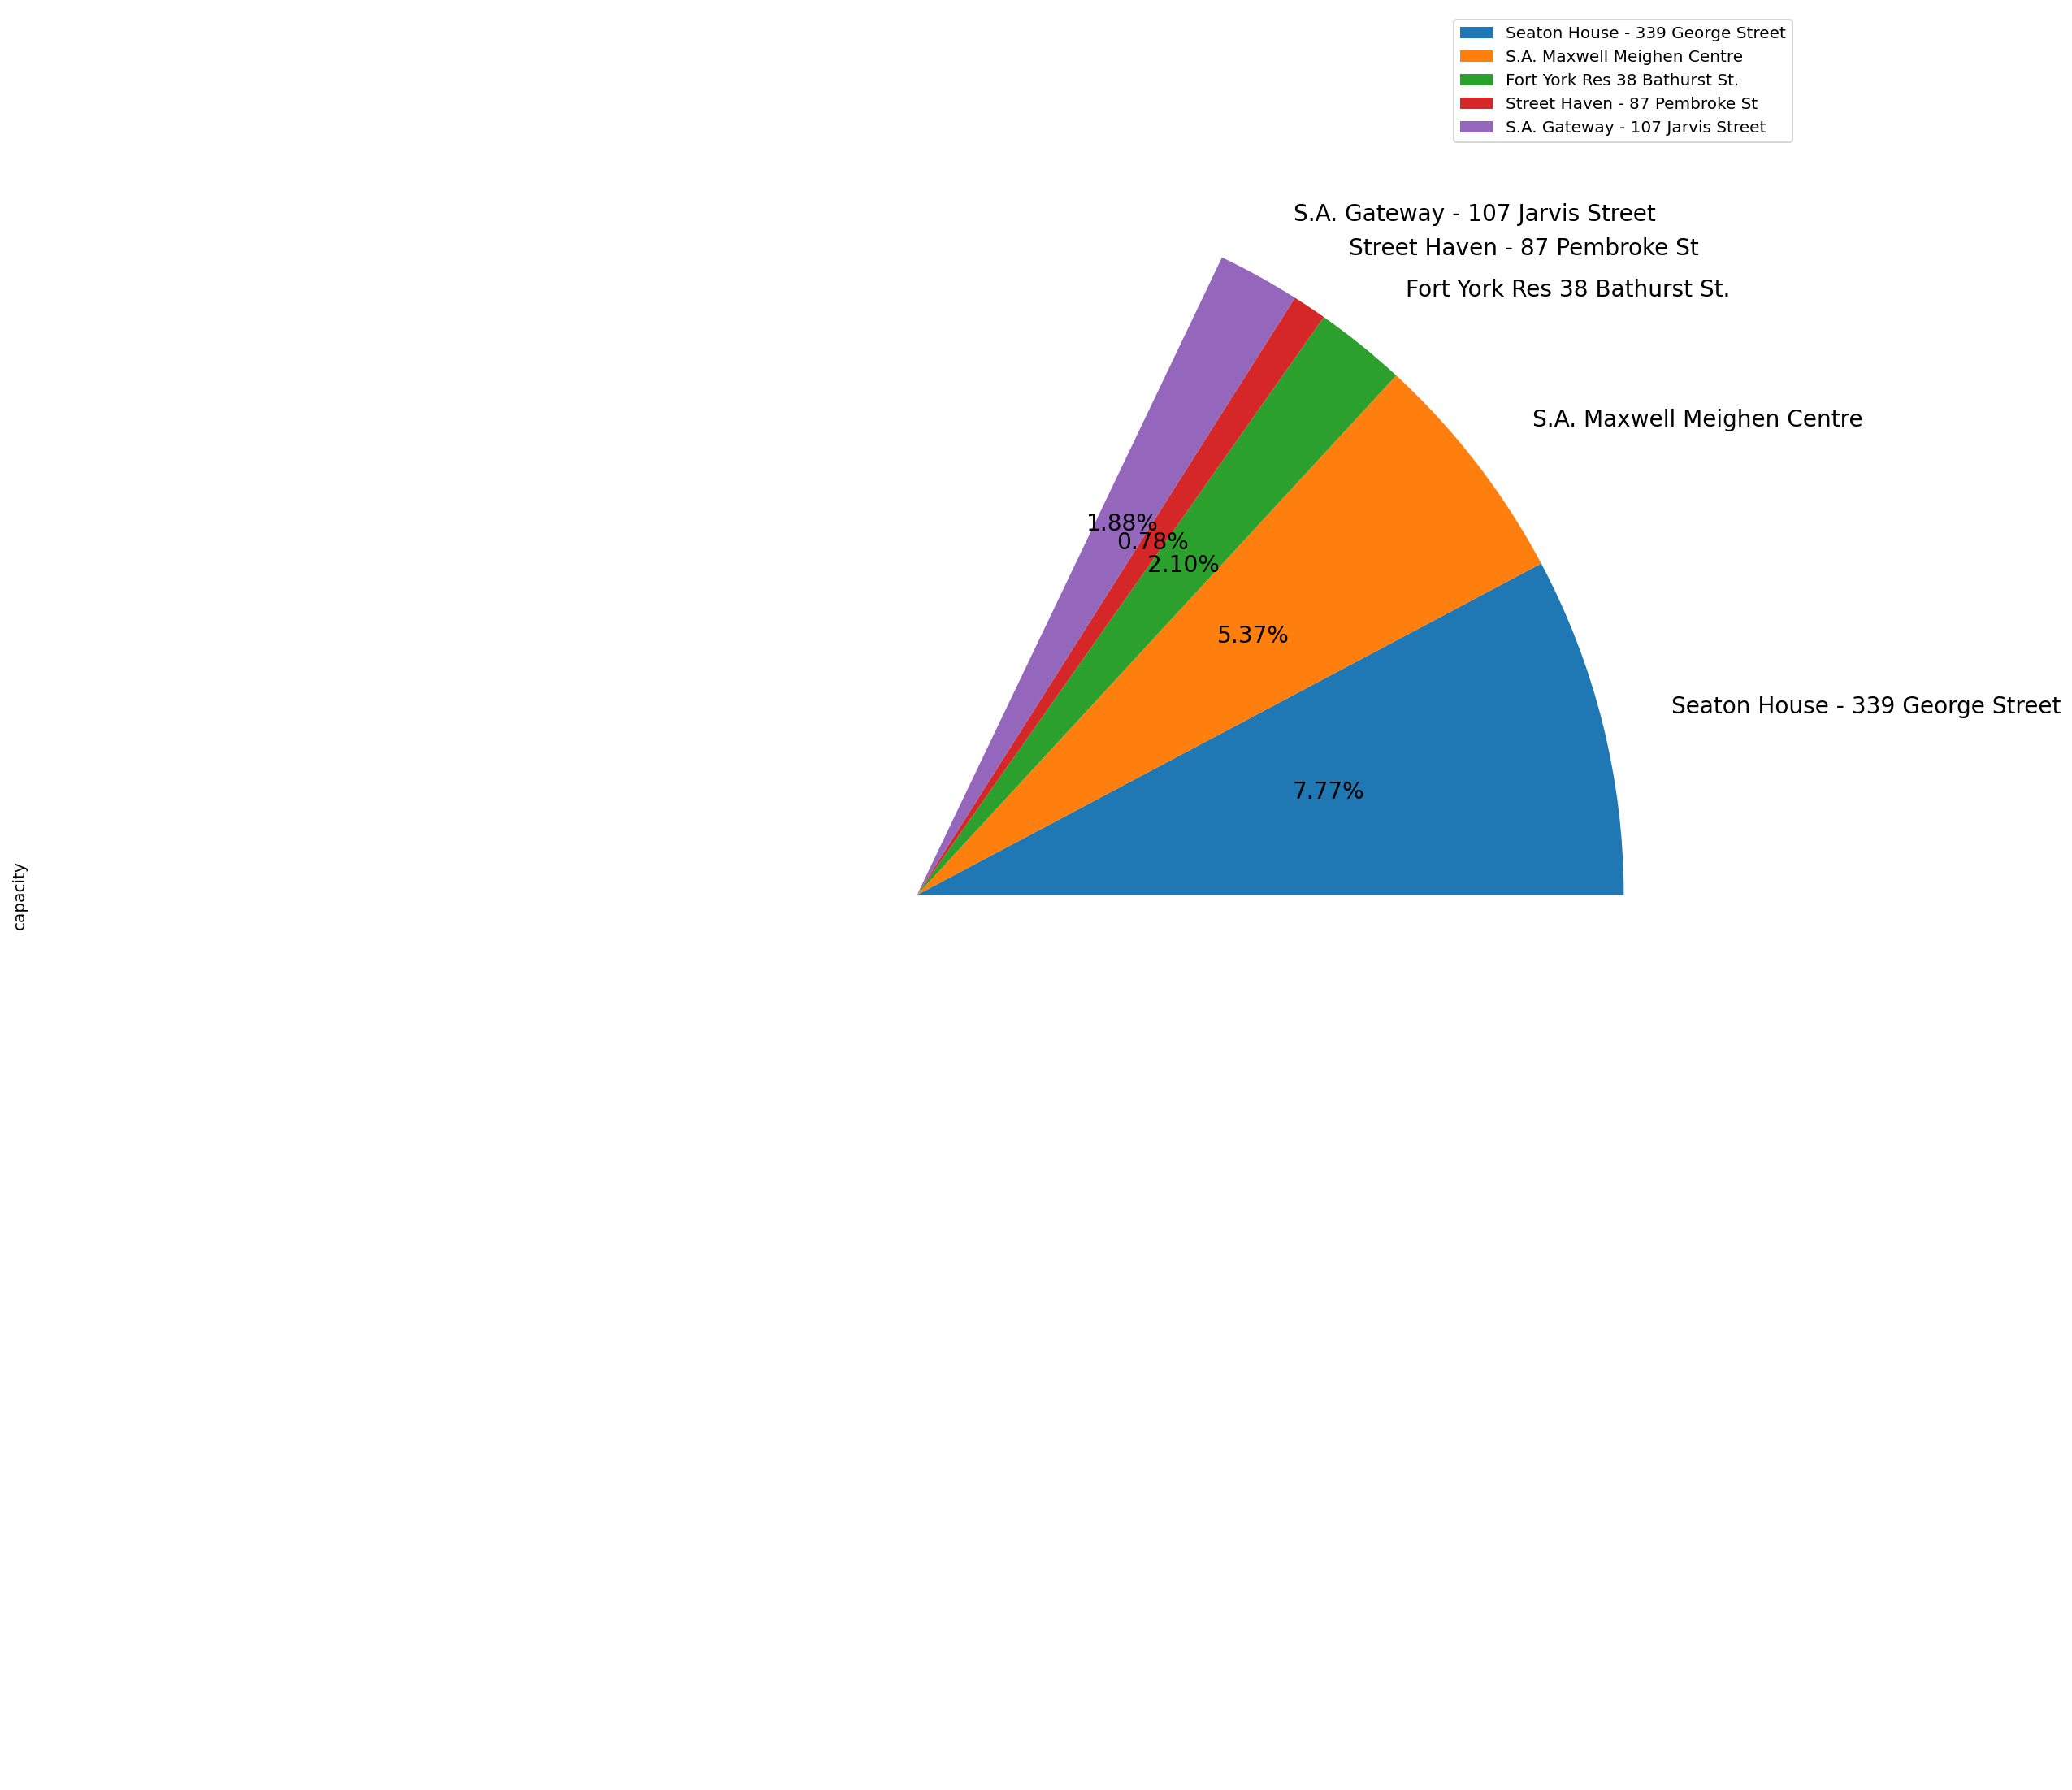

In [209]:
top_5 = daily_shelter_occupancy['facility_name'].value_counts()[:5].index.tolist()

df=daily_shelter_occupancy.groupby(['facility_name']).sum()
df=df.sort_values('capacity',ascending=False)#, inplace=True)
df.capacity=df.capacity/df.capacity.sum()
df.loc[top_5].plot.pie(y='capacity',figsize=(20,20),autopct='%1.2f%%', textprops={'fontsize': 14});

## Top 5 Shelters

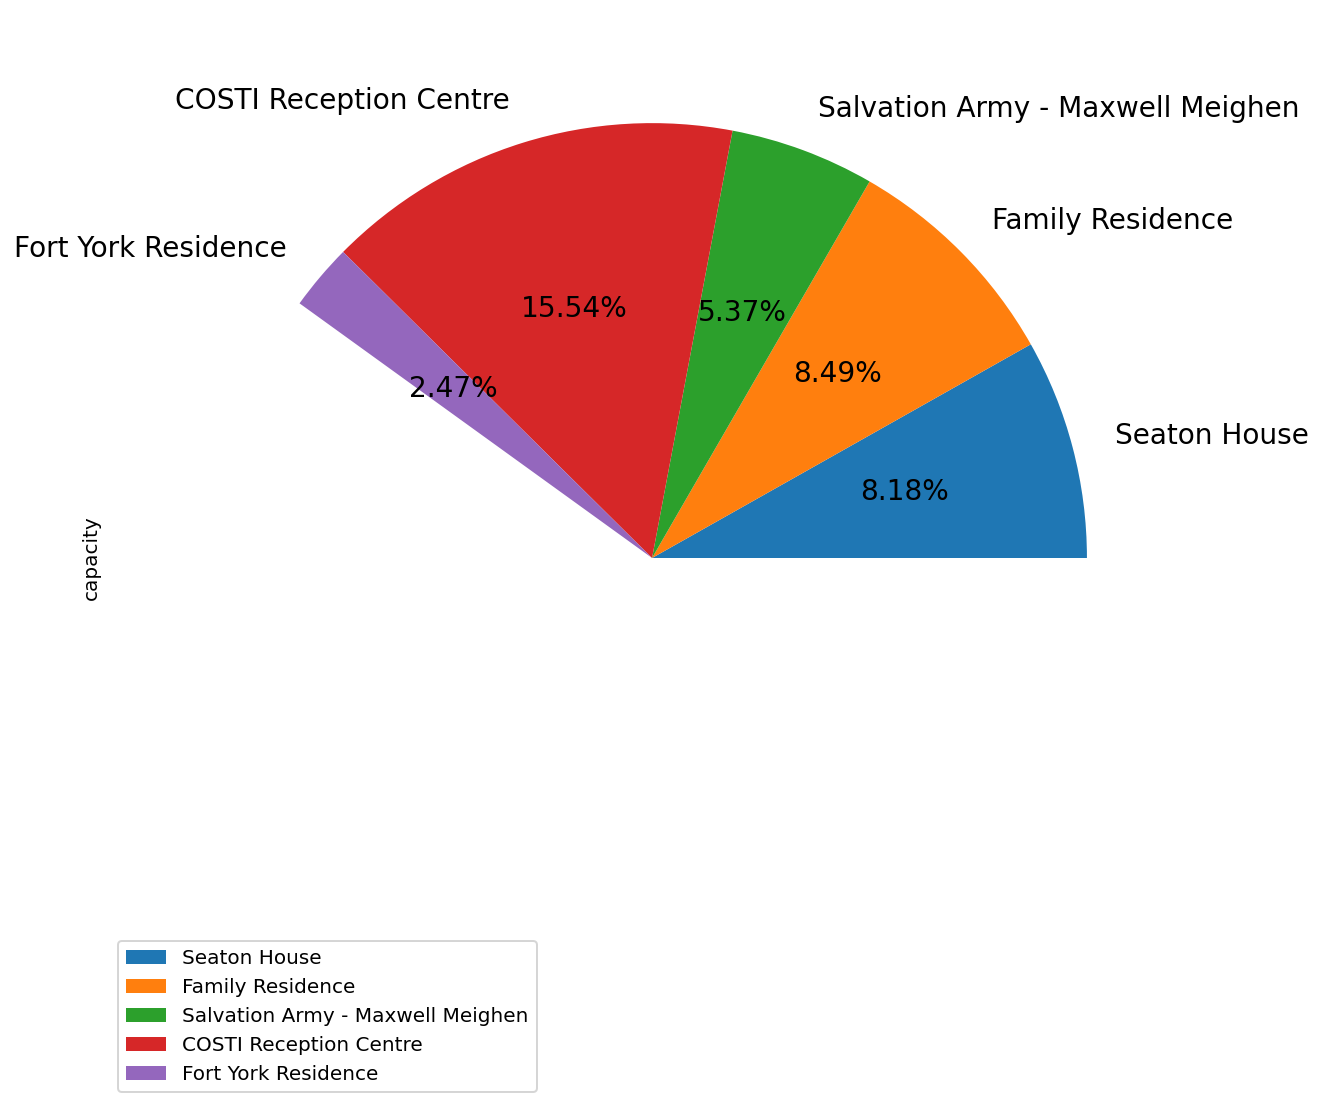

In [210]:
top_5 = daily_shelter_occupancy['shelter_name'].value_counts()[:5].index.tolist()

df=daily_shelter_occupancy.groupby(['shelter_name']).sum()
df=df.sort_values('capacity',ascending=False)#, inplace=True)
df.capacity=df.capacity/df.capacity.sum()
df.loc[top_5].plot.pie(y='capacity',figsize=(10,10),autopct='%1.2f%%', textprops={'fontsize': 14});

# EDA Q&A

## What are the capacity and occupancy trends?
1. Find daily totals at required granularity (overall, by shelter, by program, etc.)
2. Find daily averages by month and year

#### Monthly Average and Totals

### Which ORGANIZATIONS are the largest by overall capacity?

#### Find top 5 organizations

In [211]:
# IDENTIFY LIST OF "TOP 5" ORGANIZATIONS BY OVERALL CAPACITY:
#---Sum of capacity by organization_name and date in desc order of capacity for top 5 organizations
org_pivot = daily_shelter_occupancy.pivot_table('capacity','organization_name',aggfunc='sum')
org_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_5_capacity_org_list = list(org_pivot.head(5).index)
display(org_pivot.head(10))
print('\nTop 5 organizations by overall capacity:\n')
top_5_capacity_org_list

,capacity
organization_name,
City of Toronto,2405899
COSTI Immigrant Services,1086995
The Salvation Army of Canada,746376
Homes First Society,368922
The MUC Shelter Corporation,349110
Fred Victor Centre,193836
Society of St.Vincent De Paul,148182
Dixon Hall,145285
Covenant House Toronto,135780



Top 5 organizations by overall capacity:



['City of Toronto',
 'COSTI Immigrant Services',
 'The Salvation Army of Canada',
 'Homes First Society',
 'The MUC Shelter Corporation']

#### Filter and reshape data for top 5 organizations

In [212]:
# Filter main df for top 5 organizations and pivot (one capacity column per shelter)
filter = daily_shelter_occupancy.organization_name.isin(top_5_capacity_org_list)
top_5_orgs_by_capacity_df = daily_shelter_occupancy[filter]
display(top_5_orgs_by_capacity_df.head(3))

#---select columns
top_5_orgs_by_capacity_df = top_5_orgs_by_capacity_df.loc[:,['occupancy_date','organization_name','occupancy']]
display(top_5_orgs_by_capacity_df.head(3))

#---Pivot to one org per column
top_5_orgs_by_capacity_df = top_5_orgs_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['organization_name'],
    values='occupancy',
    aggfunc='sum')
display(top_5_orgs_by_capacity_df.head(3))

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
0,2017,1,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16
4,2017,5,2017-01-01,City of Toronto,Birchmount Residence,1673 Kingston Road,Toronto,ON,NaN,Birchmount Res 1673 Kingston Rd,Birchmount Residence,Men,58,60
5,2017,6,2017-01-01,City of Toronto,Birkdale Residence,1229 Ellesmere Road,Toronto,ON,M1P 4V8,Birkdale Residence,Birkdale Residence - Bedded Program,Families,168,160


,occupancy_date,organization_name,occupancy
0,2017-01-01,COSTI Immigrant Services,16
4,2017-01-01,City of Toronto,58
5,2017-01-01,City of Toronto,168


organization_name,COSTI Immigrant Services,City of Toronto,Homes First Society,The MUC Shelter Corporation,The Salvation Army of Canada
occupancy_date,,,,,
2017-01-01,16,1669,193,164,622
2017-01-02,15,1689,227,178,614
2017-01-03,16,1659,236,198,619


#### Plot capacity trends of top 5 organizations

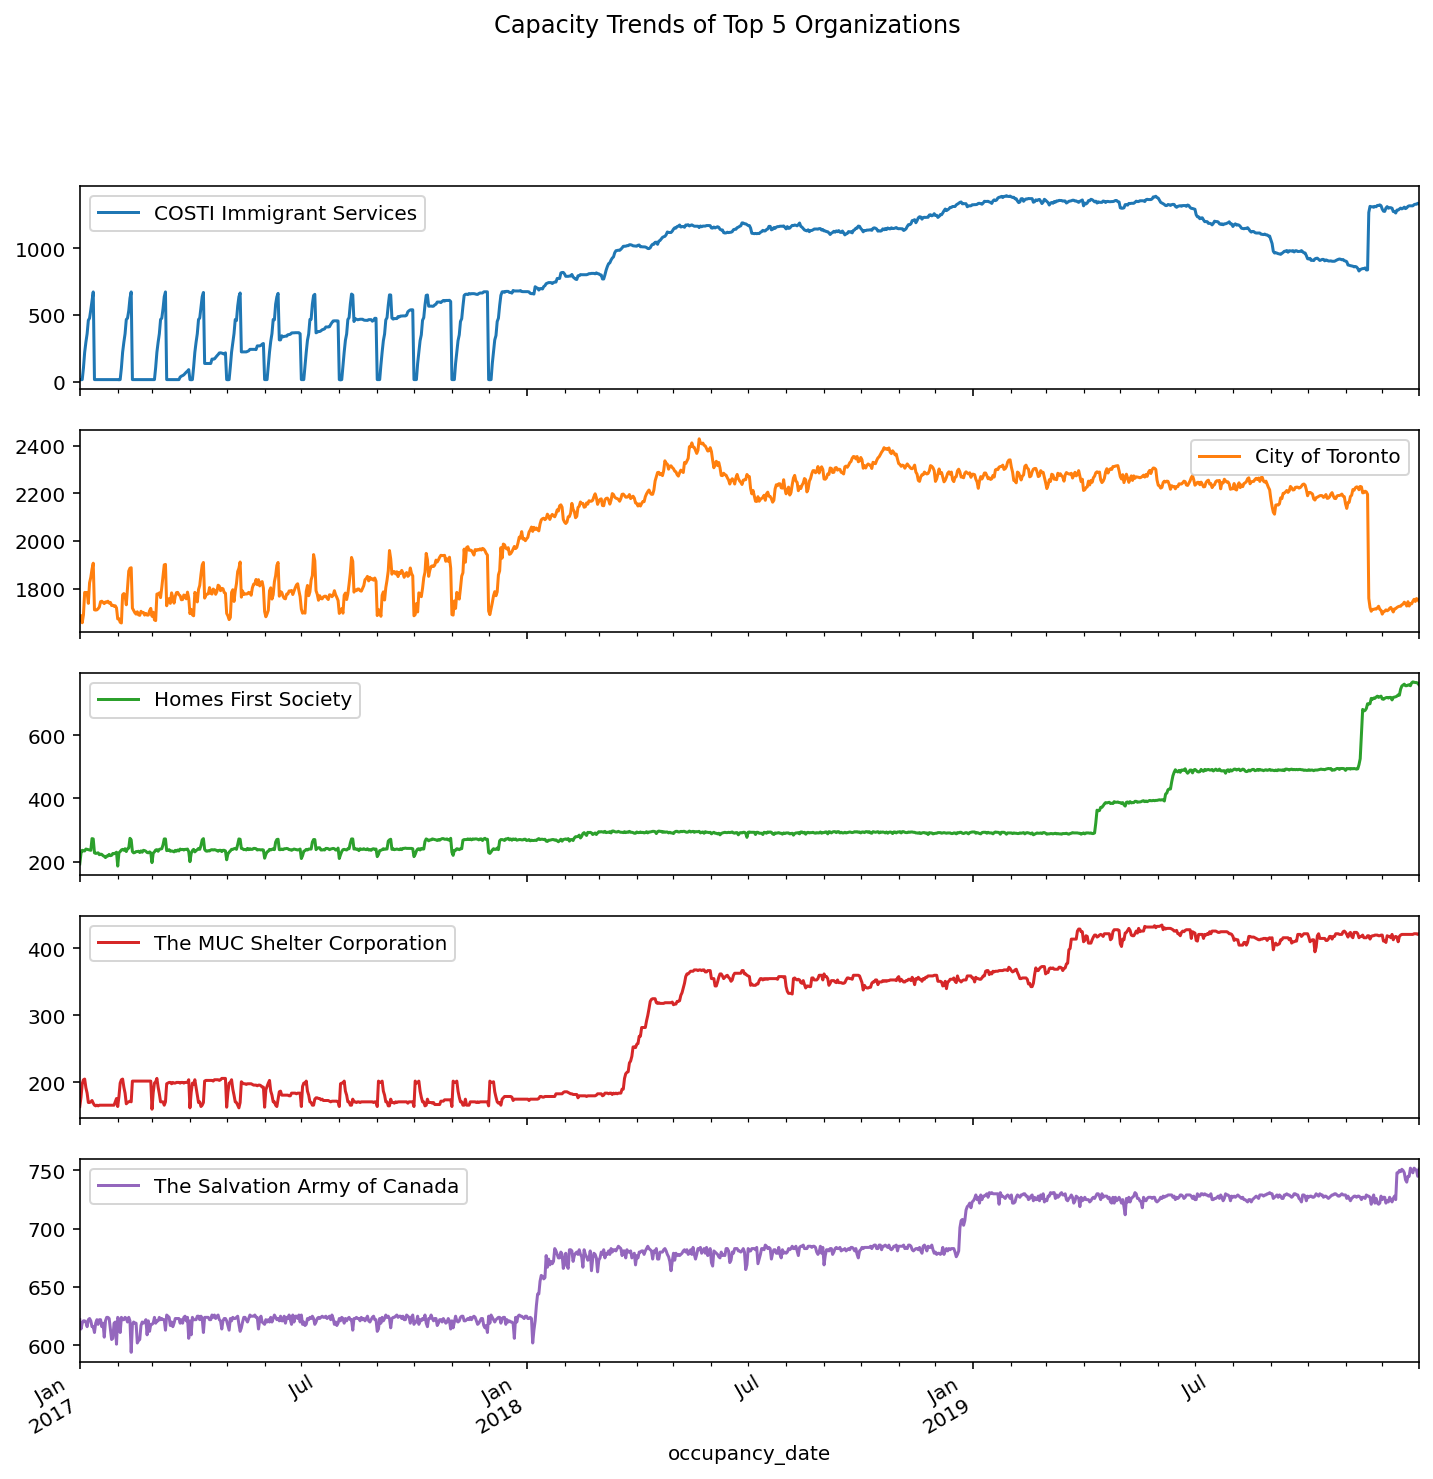

In [213]:
#-plot with subplots
top_5_orgs_by_capacity_df.plot(subplots=True, 
                               figsize=(12,12), 
                               title='Capacity Trends of Top 5 Organizations');

### Which SHELTERS are the largest by overall capacity?

#### Find top 6 shelters

In [214]:
daily_shelter_occupancy.pivot_table('capacity','shelter_name',aggfunc='sum').sort_values(by='capacity',ascending=False)[0:5].index

Index(['COSTI Reception Centre', 'Birkdale Residence', 'Family Residence',
       'Seaton House', 'Salvation Army - Maxwell Meighen'],
      dtype='object', name='shelter_name')

In [215]:
# IDENTIFY LIST OF "TOP 6" SHELTERS BY OVERALL CAPACITY:
#---Sum of capacity by shelter_name and date in desc order of capacity for top 6 shelters
shelter_pivot = daily_shelter_occupancy.pivot_table('capacity','shelter_name',aggfunc='sum')
shelter_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_6_shelters_by_capacity_list = list(shelter_pivot.head(6).index)
display(shelter_pivot.head(10))
print('\nTop 6 shelters by overall capacity:\n')
top_6_shelters_by_capacity_list

,capacity
shelter_name,
COSTI Reception Centre,1086995
Birkdale Residence,670790
Family Residence,593628
Seaton House,571935
Salvation Army - Maxwell Meighen,375965
Sojourn House,344273
Fort York Residence,172707
Women's Residence,152304
HFS - Scarborough Shelter,149452



Top 6 shelters by overall capacity:



['COSTI Reception Centre',
 'Birkdale Residence',
 'Family Residence',
 'Seaton House',
 'Salvation Army - Maxwell Meighen',
 'Sojourn House']

#### Filter and reshape data for top 6 shelters

In [216]:
# Filter main df for top 5 organizations and pivot (one capacity column per shelter)
filter = daily_shelter_occupancy.shelter_name.isin(top_6_shelters_by_capacity_list)
top_6_shelters_by_capacity_df = daily_shelter_occupancy[filter]
display(top_6_shelters_by_capacity_df.head(3))

#---select columns
top_6_shelters_by_capacity_df = top_6_shelters_by_capacity_df.loc[:,['occupancy_date','shelter_name','occupancy']]
display(top_6_shelters_by_capacity_df.head(3))

#---Pivot to one org per column
top_6_shelters_by_capacity_df = top_6_shelters_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['shelter_name'],
    values='occupancy',
    aggfunc='sum')
display(top_6_shelters_by_capacity_df.head(3))

,source_file,_id,occupancy_date,organization_name,shelter_name,shelter_address,shelter_city,shelter_province,shelter_postal_code,facility_name,program_name,sector,occupancy,capacity
0,2017,1,2017-01-01,COSTI Immigrant Services,COSTI Reception Centre,100 Lippincott Street,Toronto,ON,M5S 2P1,COSTI Reception Centre,COSTI Reception Ctr CITY Program,Co-ed,16,16
5,2017,6,2017-01-01,City of Toronto,Birkdale Residence,1229 Ellesmere Road,Toronto,ON,M1P 4V8,Birkdale Residence,Birkdale Residence - Bedded Program,Families,168,160
6,2017,7,2017-01-01,City of Toronto,Birkdale Residence,1229 Ellesmere Road,Toronto,ON,M1P 4V8,Birkdale Residence Motel (Fam),Birkdale Residence - Toronto Plaza Hotel Program,Families,119,150


,occupancy_date,shelter_name,occupancy
0,2017-01-01,COSTI Reception Centre,16
5,2017-01-01,Birkdale Residence,168
6,2017-01-01,Birkdale Residence,119


shelter_name,Birkdale Residence,COSTI Reception Centre,Family Residence,Salvation Army - Maxwell Meighen,Seaton House,Sojourn House
occupancy_date,,,,,,
2017-01-01,287,16,467,339,464,164
2017-01-02,287,15,462,336,489,166
2017-01-03,303,16,490,338,451,163


#### Plot capacity trends for top 6 shelters

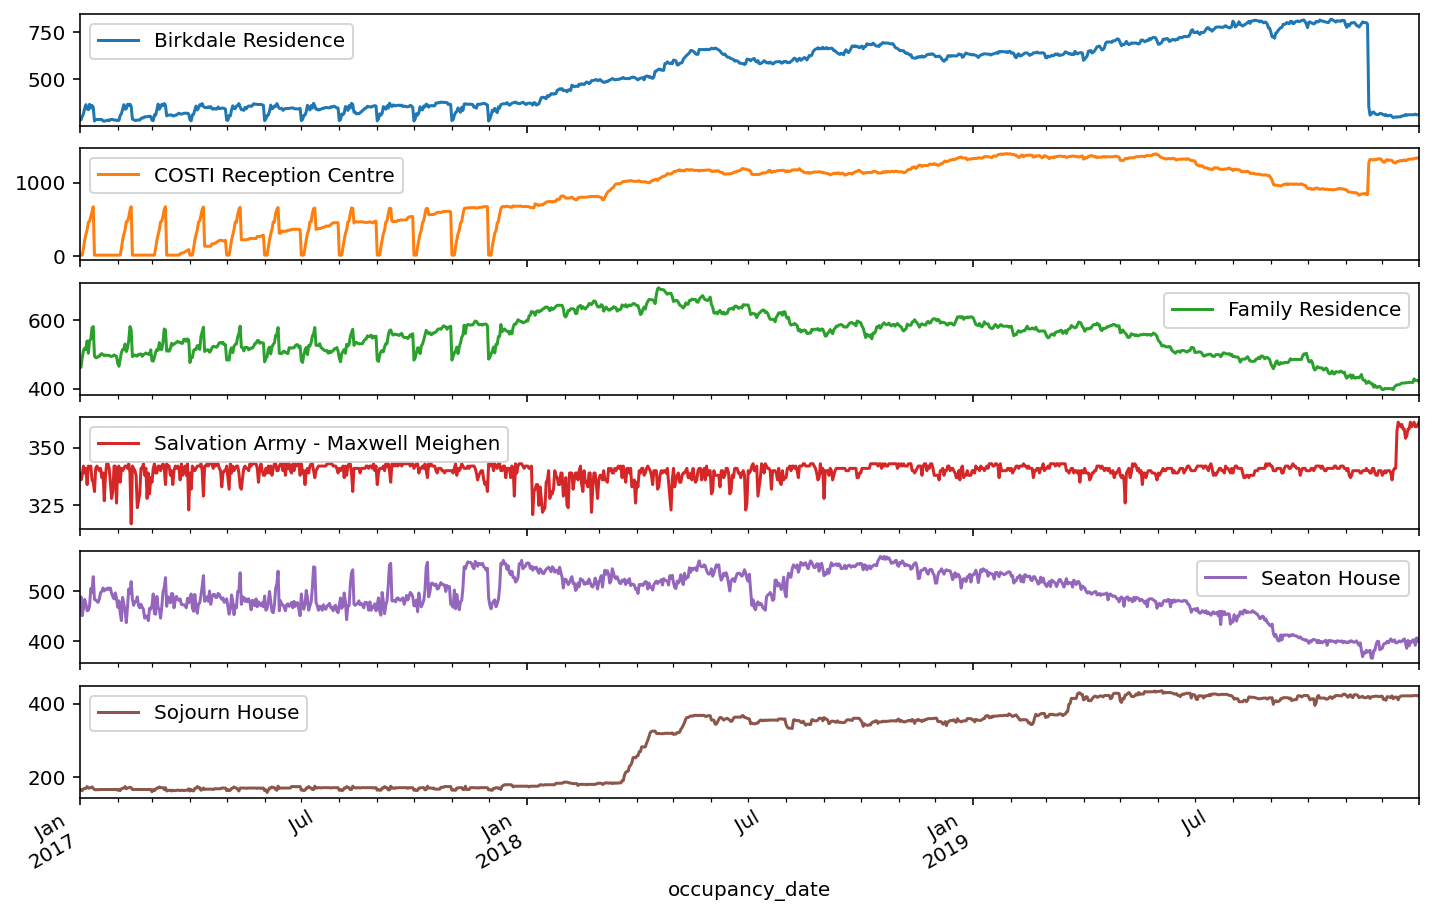

In [217]:
#-plot with subplots
top_6_shelters_by_capacity_df.plot(subplots=True, figsize=(12,8));

### Which PROGRAMS are the largest by overall capacity?

#### Find top 6 PROGRAMS

In [218]:
# IDENTIFY NAMES OF "TOP 6" PROGRAMS BY OVERALL CAPACITY (LIST!):
#---Sum of capacity by program_name and date in desc order of capacity for top 6 shelters
program_pivot = daily_shelter_occupancy.pivot_table('capacity','program_name',aggfunc='sum')
program_pivot.sort_values(by='capacity',ascending=False, inplace=True)
top_6_programs_by_capacity_list = list(program_pivot.head(6).index)
display(program_pivot.head(10))
print('\nTop 6 programs by overall capacity:\n')
top_6_programs_by_capacity_list

,capacity
program_name,
COSTI Radisson Hotel Family Program.,613282
Birkdale Residence - Toronto Plaza Hotel Program (Refugees),326084
COSTI Edward Hotel Refugee Family,324746
Salvation Army - Maxwell Meighen Emergency Bed Program,296030
Family Residence - LI Site (Internal Referral Only),275940
Seaton House - Hostel Program,248295
Birkdale Residence - Bedded Program,184532
Sojourn House - Refugee Family Hotel Program-Grange,163740
Family Residence - Main,120450



Top 6 programs by overall capacity:



['COSTI Radisson Hotel Family Program.',
 'Birkdale Residence  - Toronto Plaza Hotel Program (Refugees)',
 'COSTI Edward Hotel Refugee Family',
 'Salvation Army - Maxwell Meighen Emergency Bed Program',
 'Family Residence - LI Site (Internal Referral Only)',
 'Seaton House - Hostel Program']

#### Filter and reshape data for top 6 PROGRAMS

In [219]:
# Filter main df for top 6 PROGRAMS and pivot (one capacity column per PROGRAM)
#---select rows and columns
filter = daily_shelter_occupancy.program_name.isin(top_6_programs_by_capacity_list)
top_6_programs_by_capacity_df = daily_shelter_occupancy.loc[filter,
                                                                  ['occupancy_date','program_name','occupancy']]
display(top_6_programs_by_capacity_df.head())

#---Pivot
top_6_programs_by_capacity_df = top_6_programs_by_capacity_df.pivot_table(
    index=['occupancy_date'], 
    columns=['program_name'],
    values='occupancy',
    aggfunc='sum')

,occupancy_date,program_name,occupancy
12,2017-01-01,Family Residence - LI Site (Internal Referral ...,173
26,2017-01-01,Seaton House - Hostel Program,231
88,2017-01-01,Salvation Army - Maxwell Meighen Emergency Bed...,267
116,2017-02-01,Family Residence - LI Site (Internal Referral ...,184
130,2017-02-01,Seaton House - Hostel Program,231


#### Plot capacity trends for top 6 PROGRAMS

program_name,Birkdale Residence - Toronto Plaza Hotel Program (Refugees),COSTI Edward Hotel Refugee Family,COSTI Radisson Hotel Family Program.,Family Residence - LI Site (Internal Referral Only),Salvation Army - Maxwell Meighen Emergency Bed Program,Seaton House - Hostel Program
occupancy_date,,,,,,
2017-01-01,NaN,NaN,NaN,173.0,267.0,231.0
2017-01-02,NaN,NaN,NaN,179.0,263.0,231.0
2017-01-03,NaN,NaN,NaN,185.0,265.0,229.0
2017-01-04,NaN,NaN,NaN,199.0,270.0,229.0
2017-01-05,NaN,NaN,NaN,202.0,270.0,234.0
...,...,...,...,...,...,...
2019-12-27,0.0,NaN,770.0,159.0,290.0,164.0
2019-12-28,0.0,NaN,773.0,159.0,289.0,157.0
2019-12-29,0.0,NaN,773.0,159.0,290.0,165.0


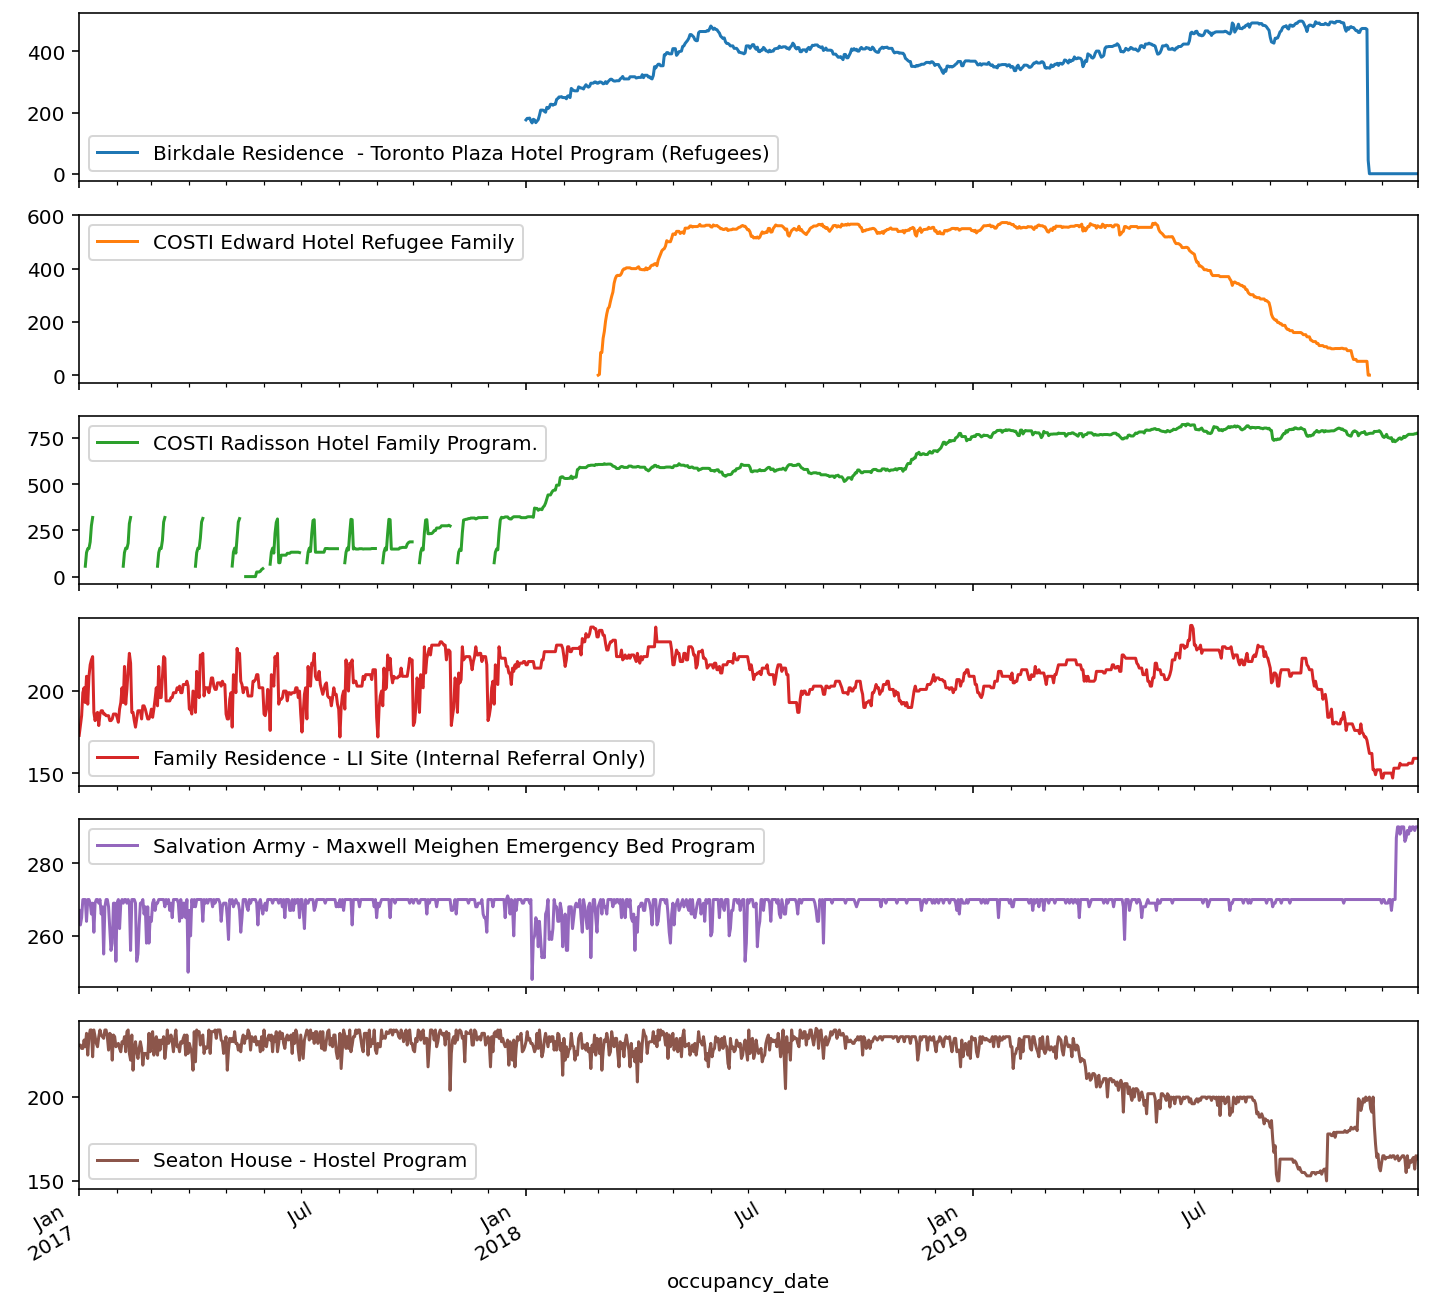

In [220]:
#-plot with subplots
display(top_6_programs_by_capacity_df)
top_6_programs_by_capacity_df.plot(subplots=True, figsize=(12,12));